In [1]:
# Bunch of imports
import sys
import argparse
import csv
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [7, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [2]:
# Auxiliary function to select a file using a Qt5 dialog
def getDataFile():
  try:
    from PyQt5.QtWidgets import QApplication, QFileDialog
    qapp = QApplication([])
    file_name, _ = QFileDialog.getOpenFileName(caption="Select csv", filter="CSV Files (*.csv);;All Files (*)")
    return file_name
  except ModuleNotFoundError:
    print("WARNING: PyQt5 seems not to be installed. Files cannot be selected using QFileDialog.")
    return None

In [3]:
# Reads a CSV file and returns a dictionary whose keys are the header entries.
# Optionally, a selected number of fields can be specified.
# You can also ask the result to be returned as a plain tuple rather than a dictionary.
#
# EXAMPLES
#
# 1) Load everything as a dictionary:
#       data = loadCsv('my_data.csv')
# 'data' will be like: {'field1': np.array(...), 'field2': np.array(...), ...}
#
# 2) Load only the given fields:
#       data = loadCsv('my_data.csv', 'field8', 'field5')
# 'data' will cointain {'field8': np.array(...), 'field5': np.array(...)}
# 
# 3) Do not create a dictionary:
#       f8,f5 = loadCsv('my_data.csv', 'field8', 'field5', as_dict=False)
# This is equivalent to the following:
#       data = loadCsv('my_data.csv', 'field8', 'field5')
#       f8 = data.get('filed8')
#       f5 = data.get('filed5')
#
def loadCsv(file_name, *fields, as_dict=True):
  with open(file_name) as f:
    # read just the header
    header = f.readline().strip().replace(" ", "").split(",")
    idx = []
    if len(fields) == 0:
      fields = header
      idx = range(len(header))
    else:
      for elem in fields:
        if elem not in header:
          raise ValueError(f"Field '{elem}' is not part of the header of the given file '{file_name}'. The header is: '{','.join(header)}'")
        idx.append(header.index(elem))
    # read again the file, using numpy
    data = np.loadtxt(f, delimiter=",")
    if as_dict:
      return {header[i]: data[:,i] for i in idx}
    else:
      return (data[:,i] for i in idx)

In [4]:
# Creates a set of subdictionaries from a dictionary created using loadCsv.
# This function is better explained via an example:
# Assume that you have the following CSV, containing data from a set of
# tests, each one having a different 'test_id' (do not focus on the content
# of 'input' and 'output'):
#
#   test_id, input, output
#         1,    10,     20
#         1,    20,     30
#         1,    30,     40
#         2,    40,     50
#         3,    50,     60
#         3,    60,     70
#         2,    70,     80
#
# It would be processed by a "plain" call to loadCsv as the following dict:
#
#   data = {
#     'test_id': np.array([1,1,1,2,3,3,2]),
#     'input': np.array([10,20,30,40,50,60,70]),
#     'output': np.array([20,30,40,50,60,70,80])
#   }
#
# However, you might want to group data depending on the test id.
# To do that, you can call thus function as:
# 
#   classify('test_id', data)
#
# The output will be another dictionary in the following form:
#
#   {
#     1: {
#       'test_id': np.array([1,1,1]),
#       'input': np.array([10,20,30]),
#       'output': np.array([20,30,40])
#     },
#     2: {
#       'test_id': np.array([2,2]),
#       'input': np.array([40,70]),
#       'output': np.array([50,80])
#     },
#     3: {
#       'test_id': np.array([3,3]),
#       'input': np.array([50,60]),
#       'output': np.array([60,70])
#     }
#   }
#
# Note that each sub-dictionary contains the only data related to a specific 'test_id' value.
def classify(key, data_dict):
  if key not in data_dict:
    raise ValueError(f"Key '{key}' is not contained in the input dictionary. Valid keys are '{data_dict.keys()}'")
  key_signal = data_dict.get(key)
  out = dict()
  for val in np.unique(data_dict.get(key)):
    idx = key_signal==val
    out[val] = dict()
    for k,v in data_dict.items():
      out[val][k] = v[idx]
  return out

In [5]:
# Measured dynamic parameters
g = 9.806 # gravity
M = 0.439 # mass of the base
m1 = 0.012 # mass of the plastic component that connects the base and the rod 
m2 = 0.019 # mass of the rod
m3 = 0.031 # mass of the terminal weight
ell = 0.495 # length of the rod
# The missing parameters are:
# - Friction coefficients
# - Inertia of the rod
# - Inertia of the weight
# NOTE: it is assumed that the total inertia at the pivot is given by:
#   I0 = m2*ell**2/4 + m3*ell**2 + I
# with I grouping all missing inertiae

In [6]:
# Try to perform identification of the parameters. The model for the pendulum
# (with no moving base!) is assumed to be given by:
#
#   \ddot{\theta} = - \frac{m*ell}{I0} g \sin\theta
#                   - \frac{\mu_d}{I0} \dot{\theta}
#                   - \frac{\mu_s}{I0} \tanh{k*\dot{\theta}}
#
# We thus run a regression to identify the vector [\frac{m*ell}{I0}, \frac{\mu_d}{I0}, \frac{\mu_s}{I0}]
# and then extract the required values

data_dict = loadCsv('logged_angles.csv', 'packet', 'time_us', 'angle')
data = classify('packet', data_dict)

# Make the problem "deterministic" (same random seed for each run)
np.random.seed(1993)

# Do we want static friction?
with_static_friction = False

# frequency and order of the butterworth filter used in smoothing
fc = 15
Nf = 4

# The problem has to be written as A*X=B, the following does precisely this!
RegA = np.zeros((0,3))
RegB = np.zeros((0,1))

for test_id, test_data in data.items():
#     if test_id != 3 and test_id != 4:
#         continue
    t = test_data.get('time_us')
    t = t / 1e6
    t = t - t[0] # t[0]=0
    tv = t[1:-1] # for velocity and acceleration signals
    dt = np.average(np.diff(t))
    # raw signals
    praw = test_data.get('angle') * (2*np.pi/4000)
    vraw = np.convolve(praw, [0.5, 0, -0.5], 'valid') / dt
    araw = np.convolve(praw, [1.0, -2.0, 1.0], 'valid') / (dt**2)
    # filter the signals
    b,a = signal.butter(Nf, 2*(dt*fc)) # [1],[1,0] = no filter
    p = signal.filtfilt(b, a, praw, padtype=None)
    v = signal.filtfilt(b, a, vraw, padtype=None)
    a = signal.filtfilt(b, a, araw, padtype=None)
    # cut left/right ends (to avoid issues with the butterworth filter)
    ncut = 2*Nf+1
    P = p[ncut+1:-(ncut+1)]
    V = v[ncut:-ncut]
    A = a[ncut:-ncut]
    # select just some samples to avoid overfitting
    keep_ratio = 5
    keep_size = round(P.size/keep_ratio)
    keep_this = np.random.choice(P.size, size=(keep_size,), replace=False)
    P = P[keep_this].reshape(-1,1)
    V = V[keep_this].reshape(-1,1)
    A = A[keep_this].reshape(-1,1)
    # Extend the regression matrix and vector
    RegA = np.vstack((  RegA , np.hstack(( g*np.sin(P) , V , np.sign(V) ))  ))
    RegB = np.vstack((RegB, -A))
    
# solve the problem  min || RegY*X - RegB ||
if with_static_friction:
    X = np.linalg.lstsq(RegA, RegB, rcond=None)[0].reshape(-1)
else:
    Xred = np.linalg.lstsq(RegA[:,:2], RegB, rcond=None)[0].reshape(-1)
    X = np.append(Xred, 0)
# Extract "real parameters":

I0 = ( (m2/2+m3)*ell ) / X[0]
I = I0 - (m2/4+m3) * ell**2
ud = X[1] * I0
us = X[2] * I0
print("I:", I)
print("ud:", ud)
print("us:", us)

# Eg:
# I = 110.5031264214593
# ud = 3.610667229143795
# us = 2.0876951758294955

I: 0.0002749181163534918
ud: 0.0007770818758243477
us: 0.0


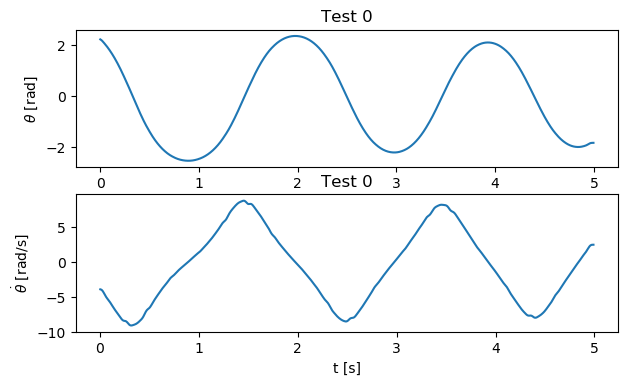

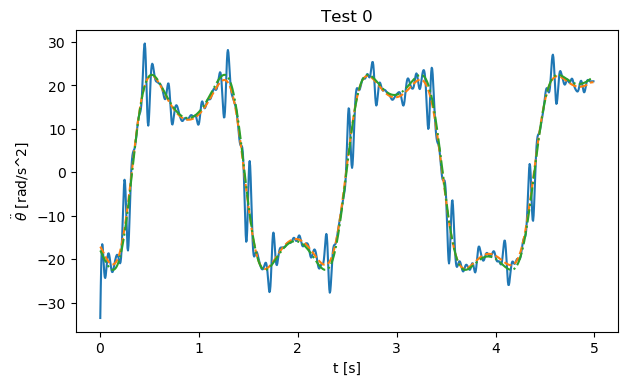

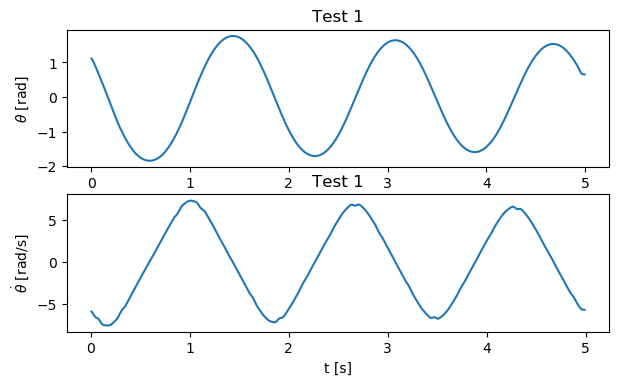

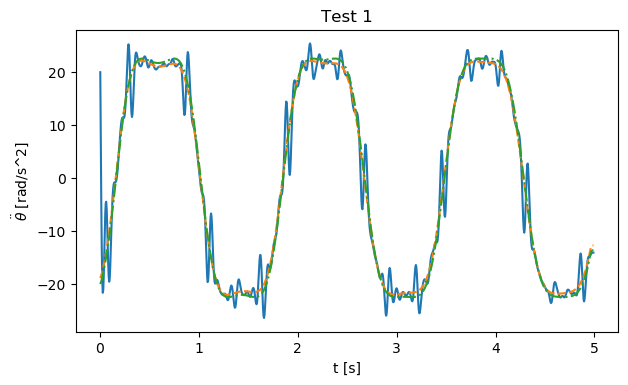

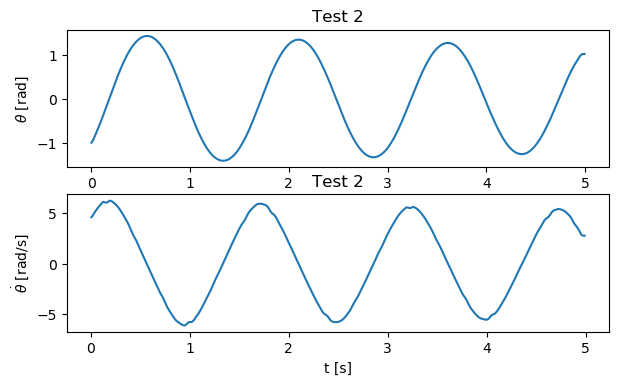

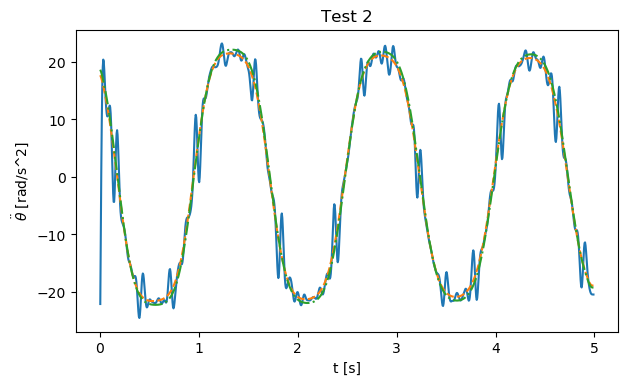

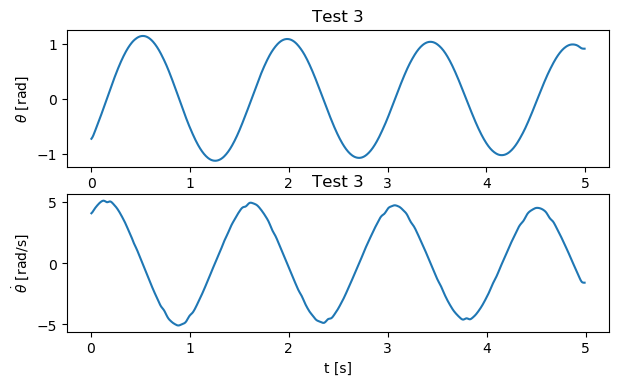

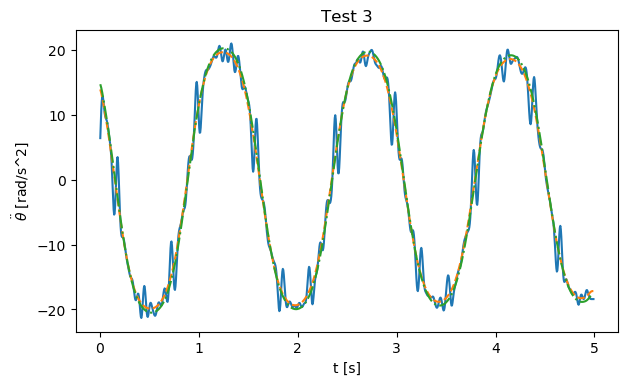

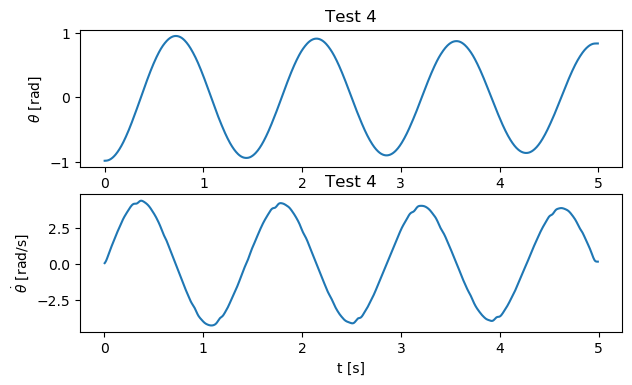

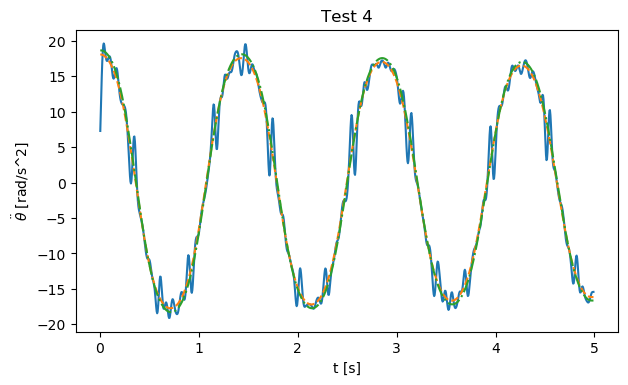

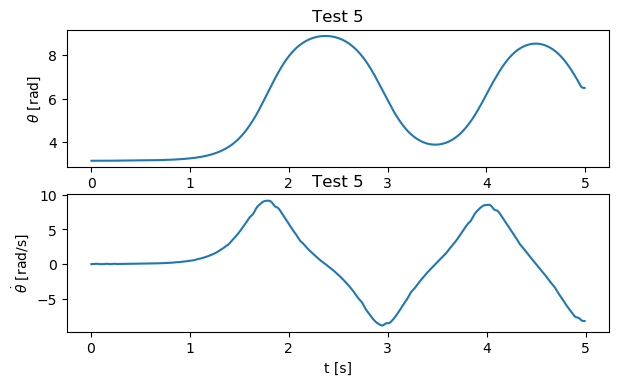

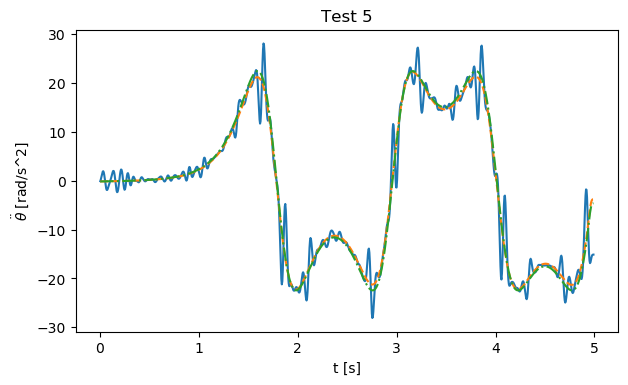

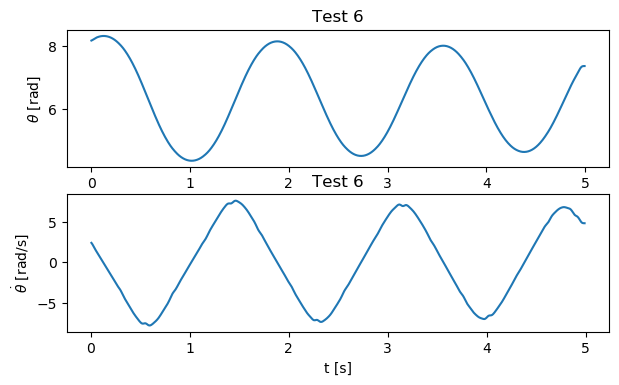

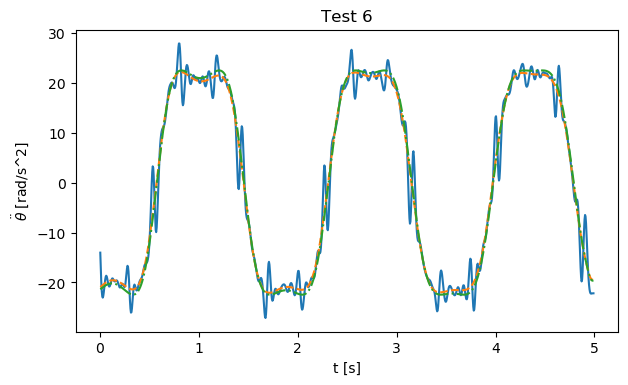

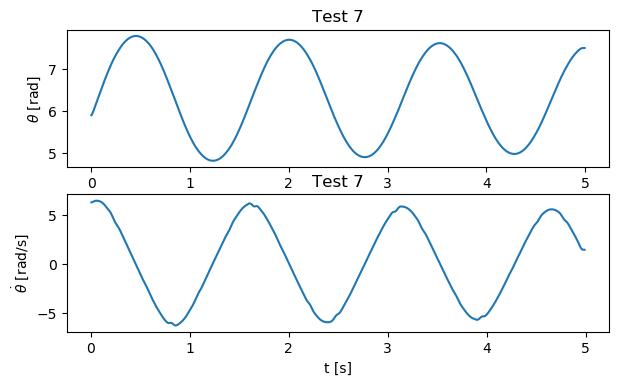

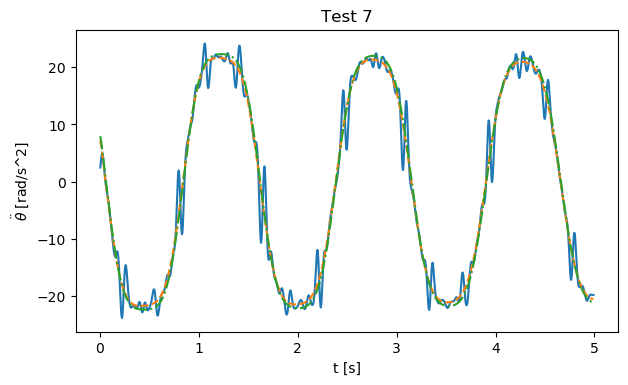

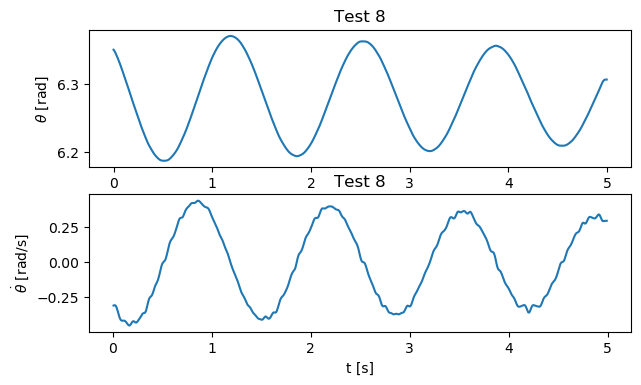

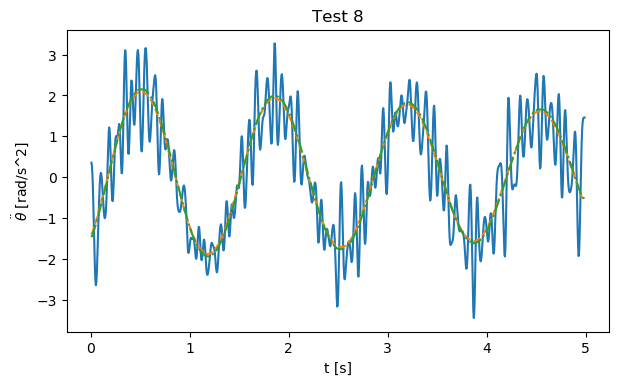

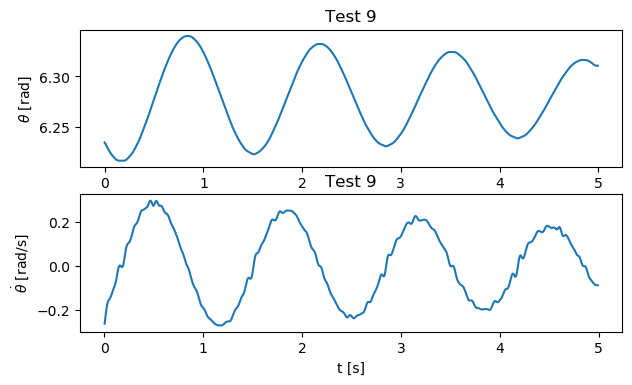

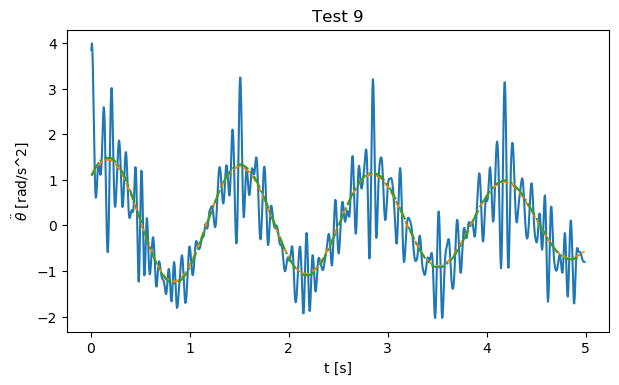

In [7]:
# Show results

for test_id, test_data in data.items():
#     fig,(pos_ax,vel_ax,acc_ax) = plt.subplots(3,1)
    fig_posvel,(pos_ax,vel_ax) = plt.subplots(2,1)
    fig_acc,acc_ax = plt.subplots()
#     vel_fig,vel_ax = plt.subplots()
#     acc_fig,acc_ax = plt.subplots()
    t = test_data.get('time_us')
    t = t / 1e6
    t = t - t[0] # t[0]=0
    t2 = t[1:-1] # for velocity and acceleration signals
    dt = np.average(np.diff(t))
    # raw signals
    praw = test_data.get('angle') * (2*np.pi/4000)
    vraw = np.convolve(praw, [0.5, 0, -0.5], 'valid') / dt
    araw = np.convolve(praw, [1.0, -2.0, 1.0], 'valid') / (dt**2)
    # filter the signals
    b,a = signal.butter(Nf, 2*(dt*fc)) # [1],[1,0] = no filter
    pos = signal.filtfilt(b, a, praw, padtype=None)
    vel = signal.filtfilt(b, a, vraw, padtype=None)
    acc = signal.filtfilt(b, a, araw, padtype=None)
    # "prediction"
    ahat = - ((m2/2+m3)*ell/I0) * g * np.sin(pos[1:-1]) - (ud/I0) * vel - (us/I0) * np.sign(vel)
    ahat_simple = - (2*m2+4*m3)/((m2+4*m3)*ell) * g * np.sin(pos[1:-1])
    pos_ax.plot(t, pos)
    vel_ax.plot(t2, vel)
    acc_ax.plot(t2, acc)
    acc_ax.plot(t2, ahat, '--')
    acc_ax.plot(t2, ahat_simple, '-.')
    
    pos_ax.set_title(f"Test {int(test_id)}")
    pos_ax.set_xlabel('t [s]')
    pos_ax.set_ylabel('$\\theta$ [rad]')
    vel_ax.set_title(f"Test {int(test_id)}")
    vel_ax.set_xlabel('t [s]')
    vel_ax.set_ylabel('$\\dot{\\theta}$ [rad/s]')
    acc_ax.set_title(f"Test {int(test_id)}")
    acc_ax.set_xlabel('t [s]')
    acc_ax.set_ylabel('$\\ddot{\\theta}$ [rad/s^2]')
    

In [18]:
# The regression this time follows the following model:
#
#   u = [ pdd  0  pd sgn(pd)  0 (tdd*ct-td**2*st) ] * X
#   0 = [  0  tdd  0    0    td   (pdd*ct+g*st)   ] * X
#
# In which the parameter vector is given by:
#
#   X^T = [
#     (m_b + m1 + m2 + m3) / alpha
#     (I + m2*ell**2/4 + m3*ell**2) / alpha
#     fd / alpha
#     fs / alpha
#     tau_v / alpha
#     (m2*ell/2 + m3*ell) / alpha
#   ]
#
data_dict = loadCsv('logged_motion.csv', 'time_us', 'pwm', 'position', 'angle')
data = classify('pwm', data_dict)

# Make the problem "deterministic" (same random seed for each run)
np.random.seed(1993)

# Do we want static friction?
with_static_friction = True
estimate_first_order_moment = False

# frequency and order of the butterworth filter used in smoothing
fc = 15
Nf = 4

# The problem has to be written as A*X=B, the following does precisely this!
RegA = np.zeros((0,6))
RegB = np.zeros((0,1))

for test_id, test_data in data.items():
    t = test_data.get('time_us')
    t = t / 1e6
    t = t - t[0] # t[0]=0
    tv = t[1:-1] # for velocity and acceleration signals
    dt = np.average(np.diff(t))
    # raw signals
    pos_raw = test_data.get('position')
    dpos_raw = np.convolve(pos_raw, [0.5, 0, -0.5], 'valid') / dt
    ddpos_raw = np.convolve(pos_raw, [1.0, -2.0, 1.0], 'valid') / (dt**2)
    ang_raw = test_data.get('angle') * (2*np.pi/4000)
    dang_raw = np.convolve(ang_raw, [0.5, 0, -0.5], 'valid') / dt
    ddang_raw = np.convolve(ang_raw, [1.0, -2.0, 1.0], 'valid') / (dt**2)
    u_raw = test_data.get('pwm')
    # filter the signals
    b,a = signal.butter(Nf, 2*(dt*fc)) # [1],[1,0] = no filter
    pos = signal.filtfilt(b, a, pos_raw, padtype=None)
    dpos = signal.filtfilt(b, a, dpos_raw, padtype=None)
    ddpos = signal.filtfilt(b, a, ddpos_raw, padtype=None)
    ang = signal.filtfilt(b, a, ang_raw, padtype=None)
    dang = signal.filtfilt(b, a, dang_raw, padtype=None)
    ddang = signal.filtfilt(b, a, ddang_raw, padtype=None)
    u = signal.filtfilt(b, a, u_raw, padtype=None)
    # cut left/right ends (to avoid issues with the butterworth filter)
    ncut = 2*Nf+1
    P = pos[ncut+1:-(ncut+1)]
    dP = dpos[ncut:-ncut]
    ddP = ddpos[ncut:-ncut]
    T = ang[ncut+1:-(ncut+1)]
    dT = dang[ncut:-ncut]
    ddT = ddang[ncut:-ncut]
    U = u[ncut:-ncut]
    # select just some samples to avoid overfitting
    keep_ratio = 5
    keep_size = round(P.size/keep_ratio)
    keep_this = np.random.choice(P.size, size=(keep_size,), replace=False)
    P = P[keep_this].reshape(-1,1)
    dP = dP[keep_this].reshape(-1,1)
    ddP = ddP[keep_this].reshape(-1,1)
    T = T[keep_this].reshape(-1,1)
    dT = dT[keep_this].reshape(-1,1)
    ddT = ddT[keep_this].reshape(-1,1)
    U = U[keep_this].reshape(-1,1)
    # Extend the regression matrix and vector
    O = np.zeros(P.shape)
    RegA = np.vstack((  RegA , np.hstack(( ddP, O, dP, np.sign(dP), O, (ddT*np.cos(T)-dT**2*np.sin(T)) ))  ))
    RegB = np.vstack((RegB, U))
    RegA = np.vstack((  RegA , np.hstack(( O, ddT, O, O, dT, (ddP*np.cos(T)+g*np.sin(T)) ))  ))
    RegB = np.vstack((RegB, O))

# solve the problem  min || RegY*X - RegB ||
if with_static_friction:
    X = np.linalg.lstsq(RegA, RegB, rcond=None)[0].reshape(-1)
else:
    RegA[:,[0,1,2,4,5]]
    Xred = np.linalg.lstsq(RegA, RegB, rcond=None)[0].reshape(-1)
    X = np.array([Xred[0], Xred[1], Xred[2], 0, Xred[3], Xred[4]])

# Extract parameters:
ma = X[0]
Ia = X[1]
fva = X[2]
fsa = X[3]
tva = X[4]
mua = X[5]

print("Dynamic parameters:")
print("ma:", ma)
print("Ia:", Ia)
print("fva:", fva)
print("fsa:", fsa)
print("tva:", tva)
print("mua:", mua)

Dynamic parameters:
ma: 11.989528085989038
Ia: -0.11909071982066166
fva: 406.0885071707636
fsa: 16.33900992267232
tva: -0.603533743086908
mua: -0.01633885731853213


<ipython-input-27-ebf6e5a54a09>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1,(p_ax,pd_ax) = plt.subplots(2,1)
<ipython-input-27-ebf6e5a54a09>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2,pdd_ax = plt.subplots()
<ipython-input-27-ebf6e5a54a09>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig3,(t_ax,td_a

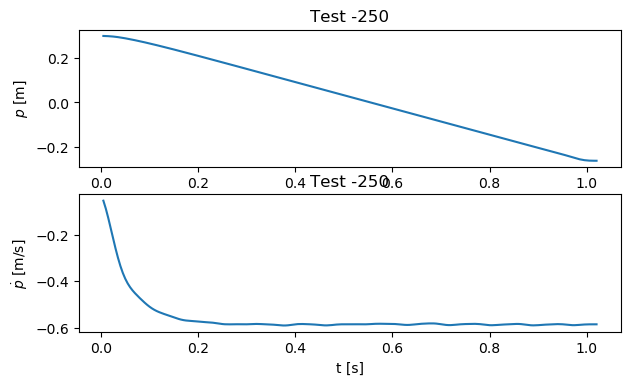

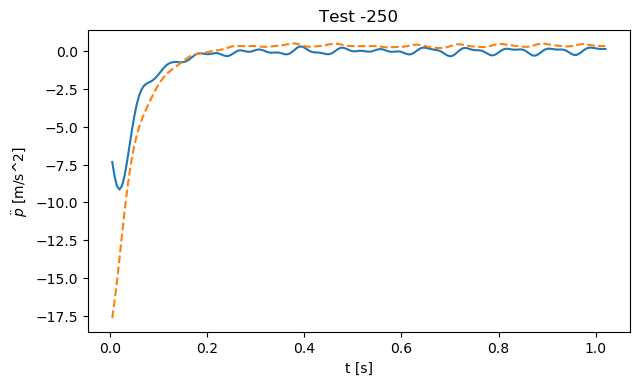

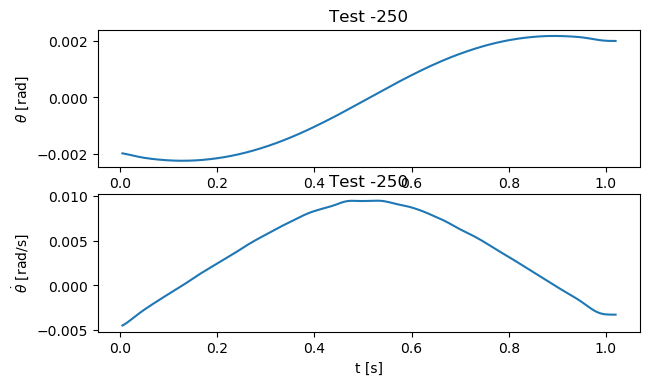

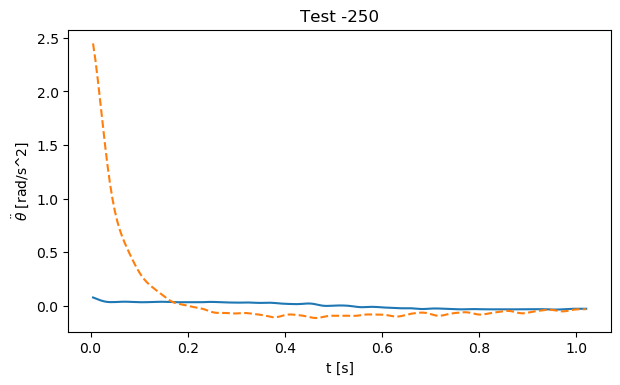

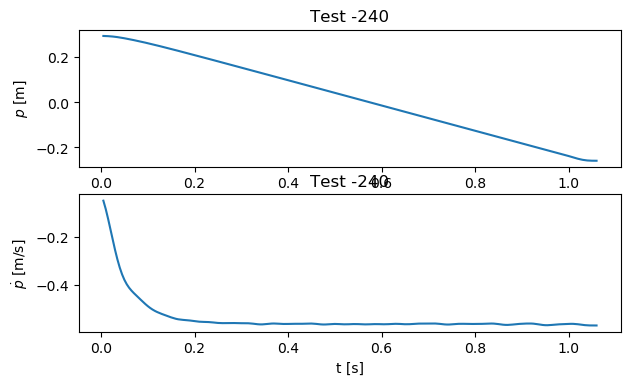

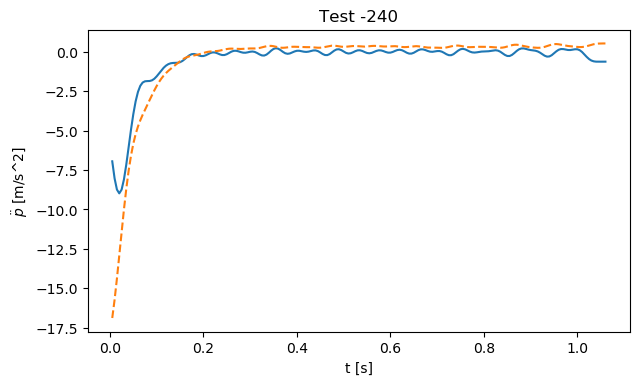

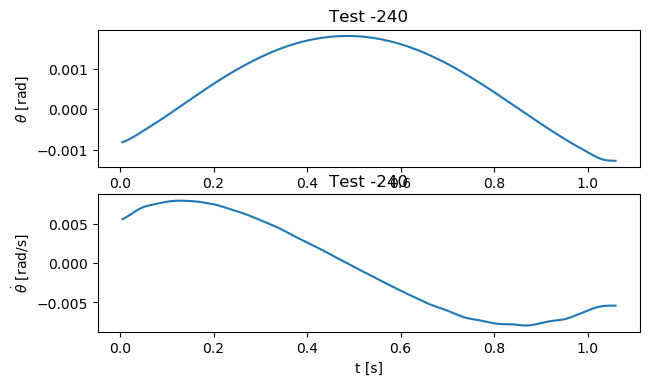

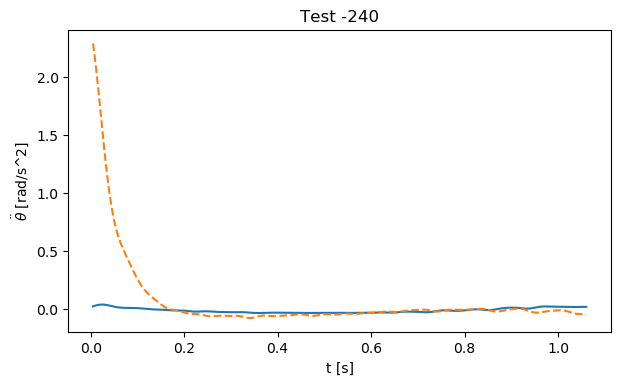

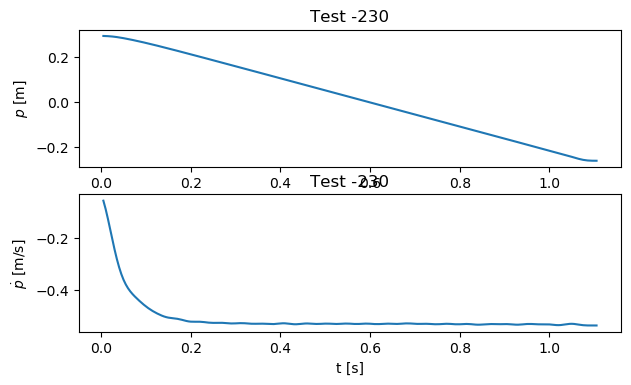

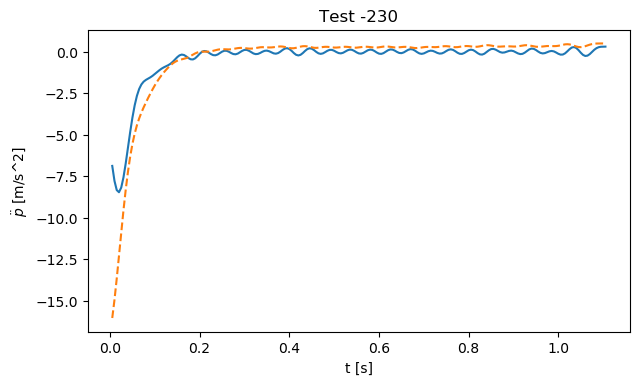

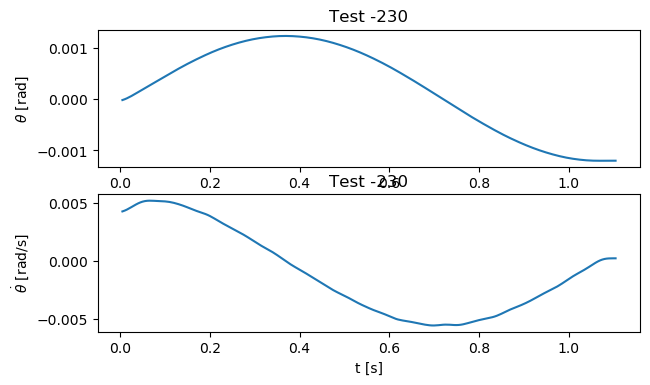

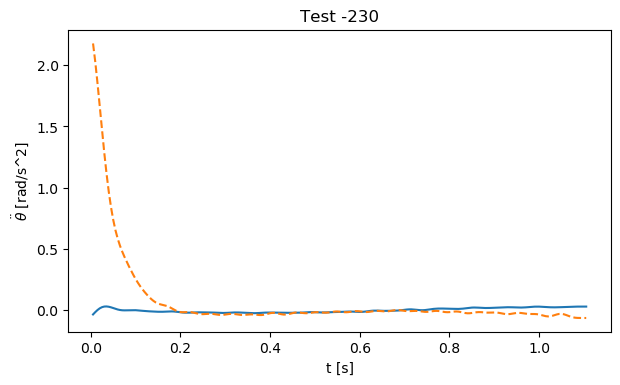

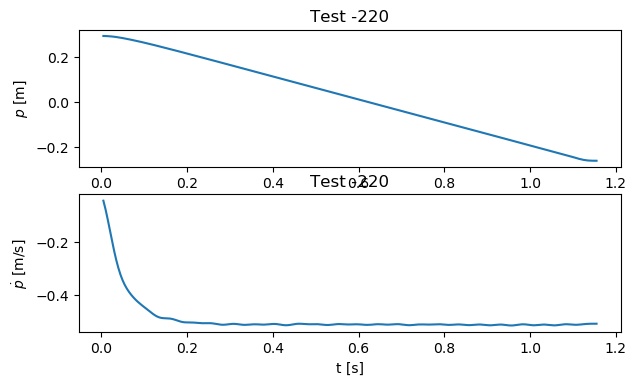

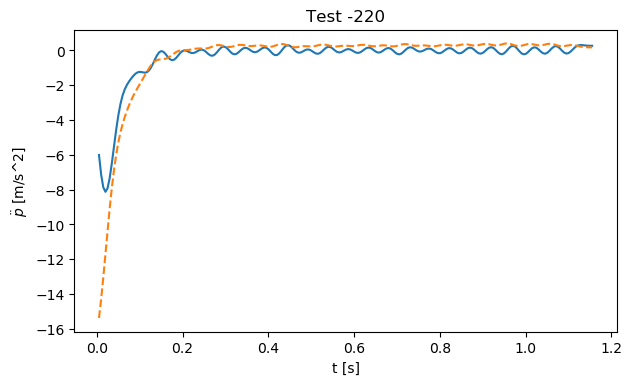

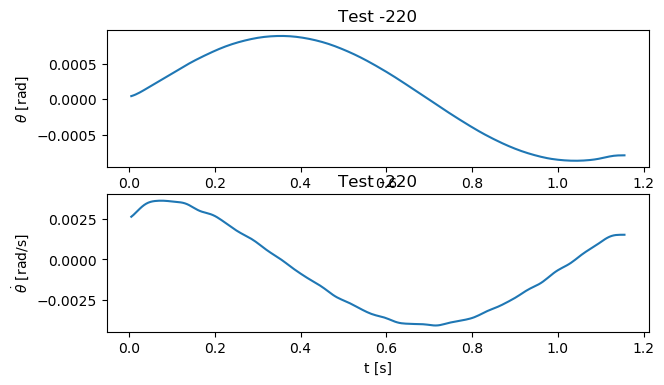

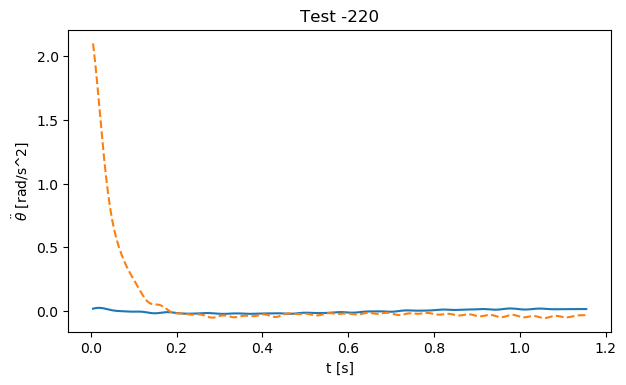

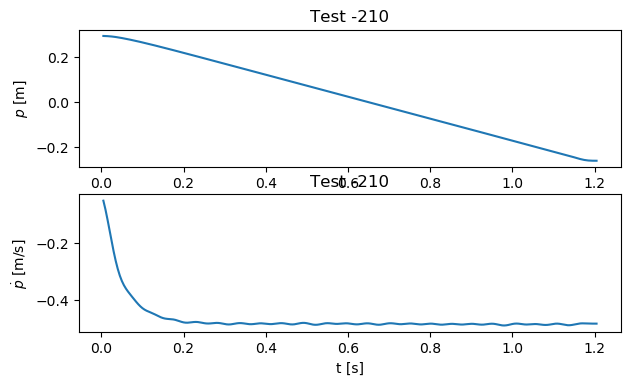

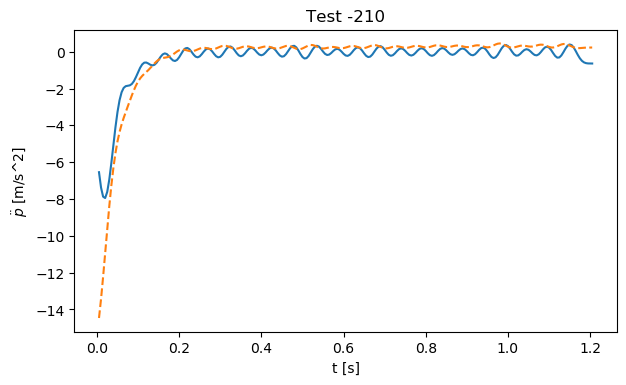

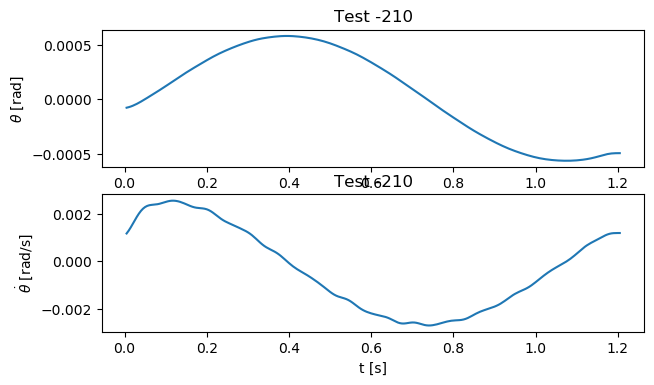

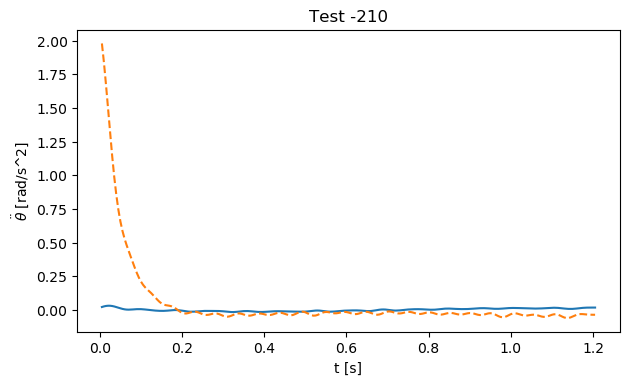

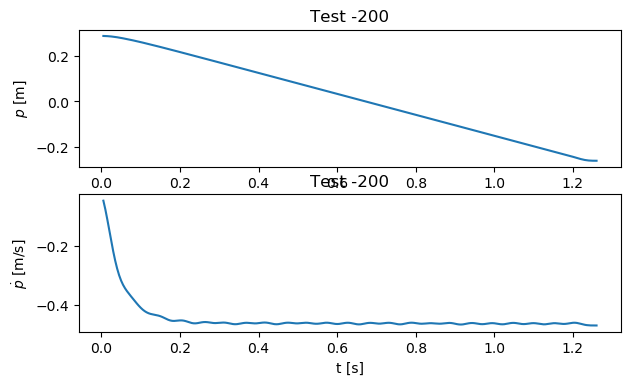

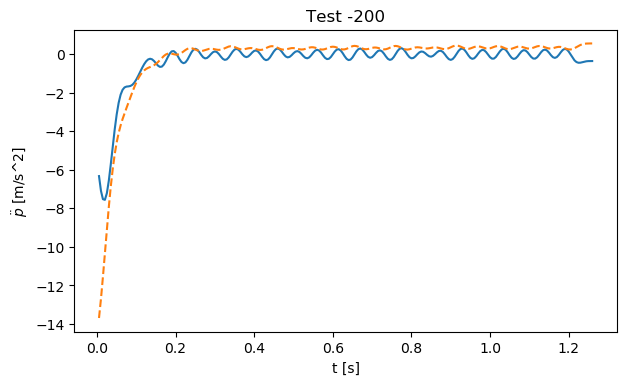

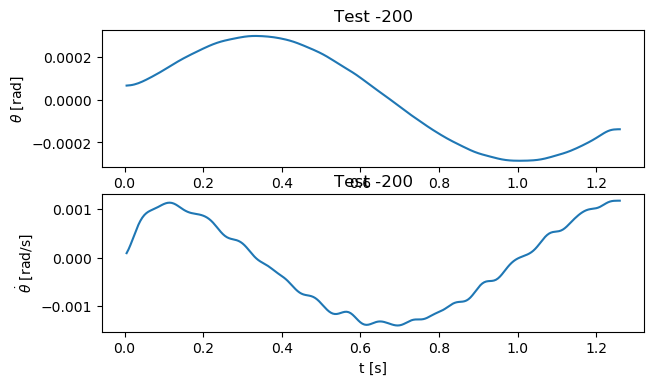

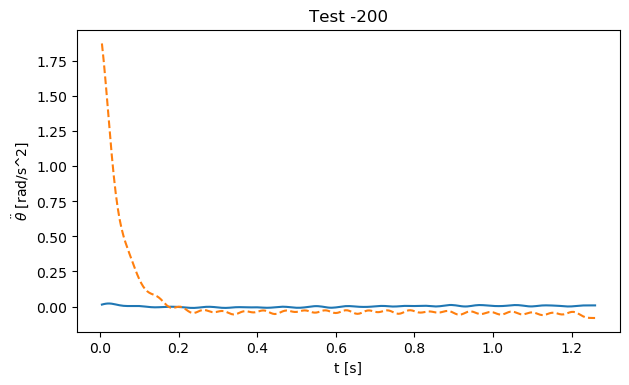

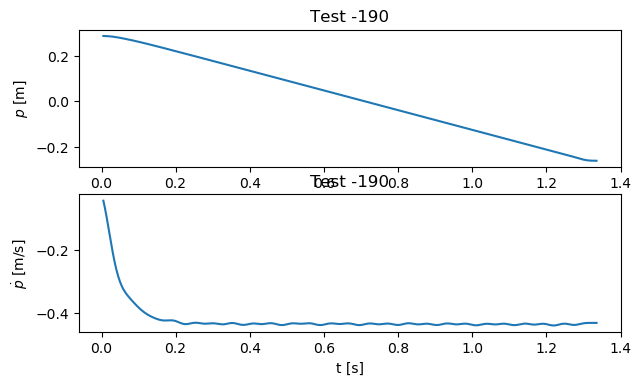

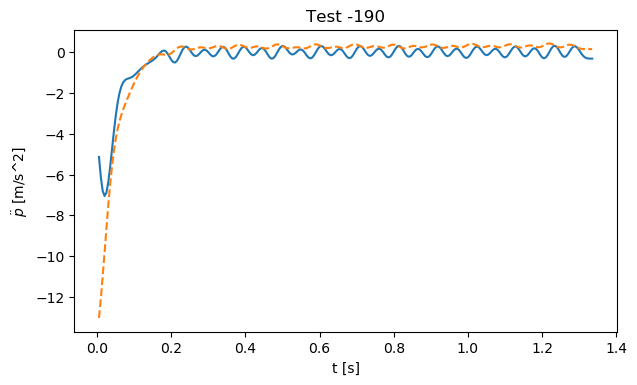

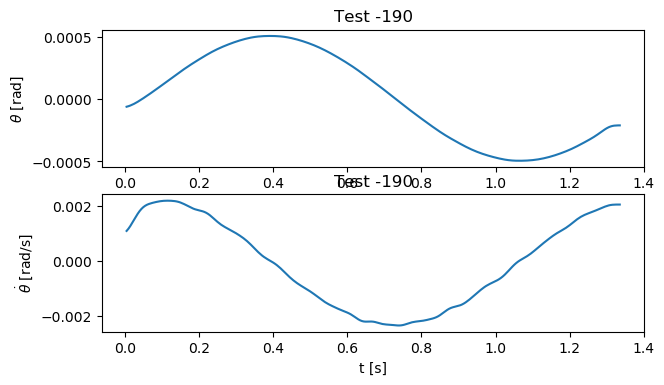

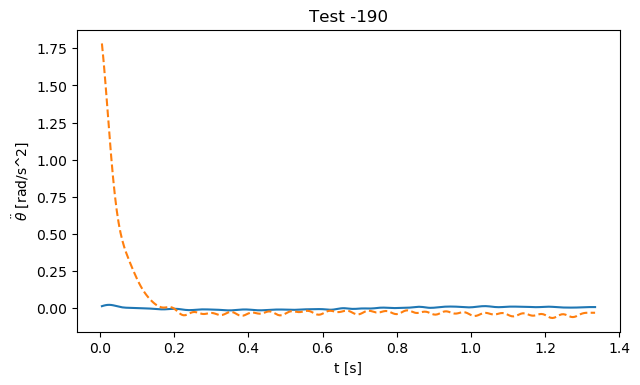

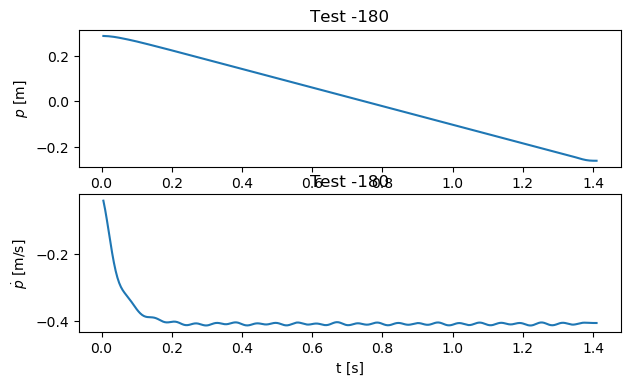

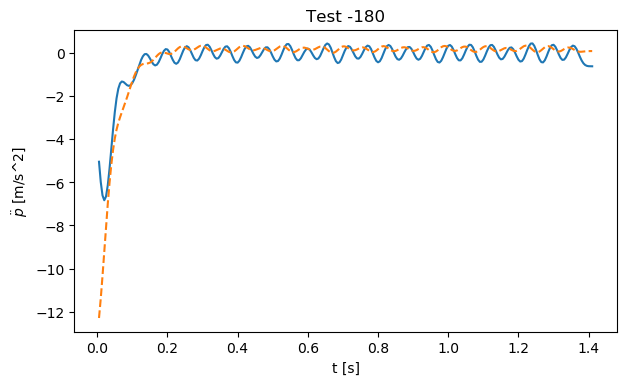

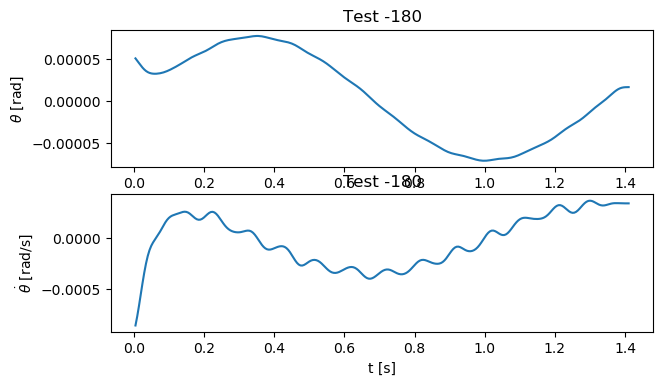

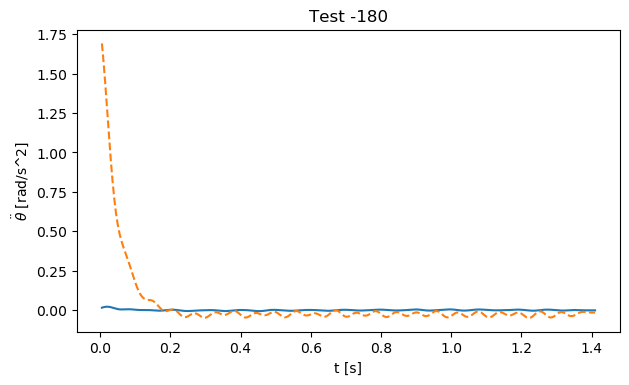

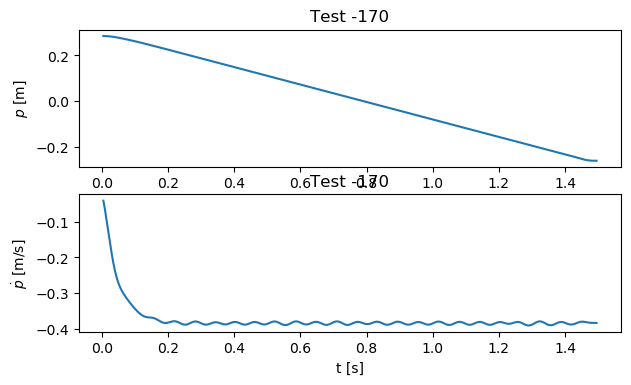

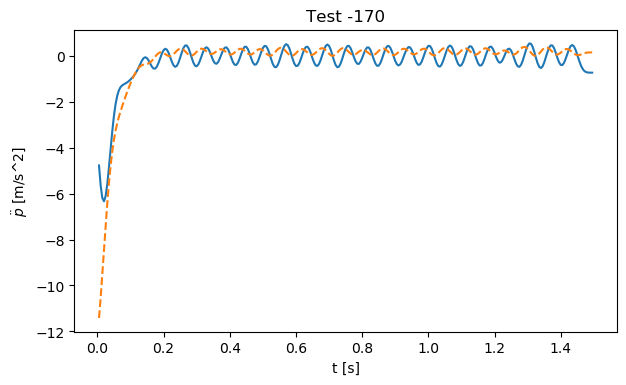

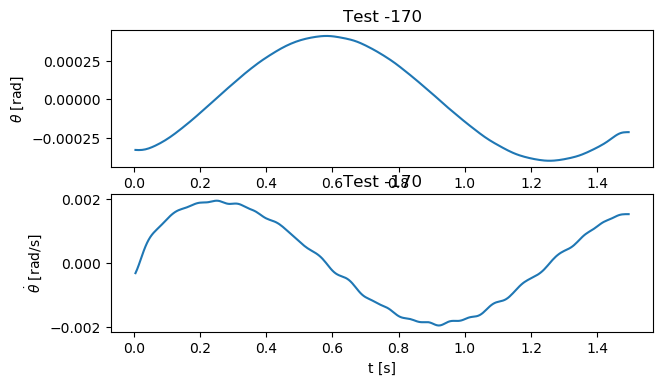

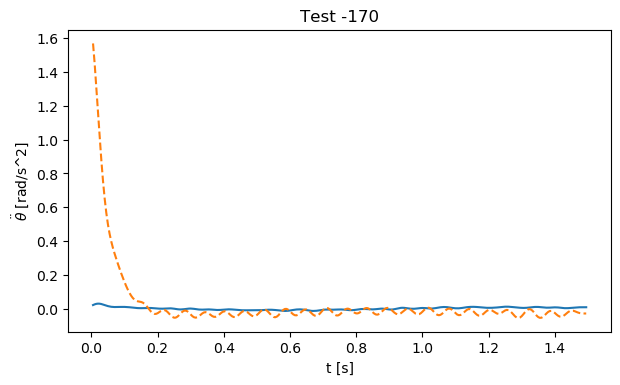

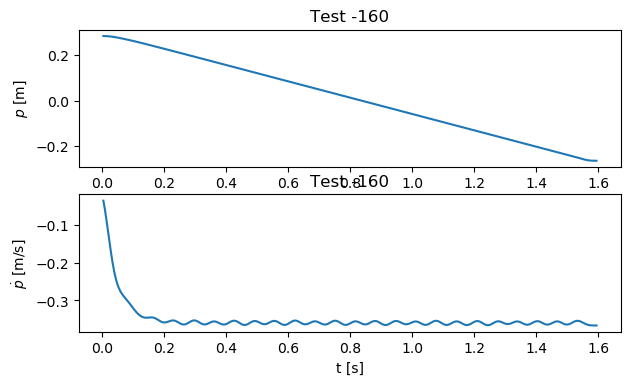

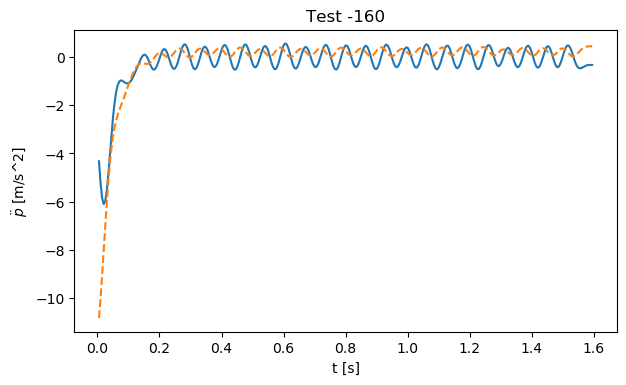

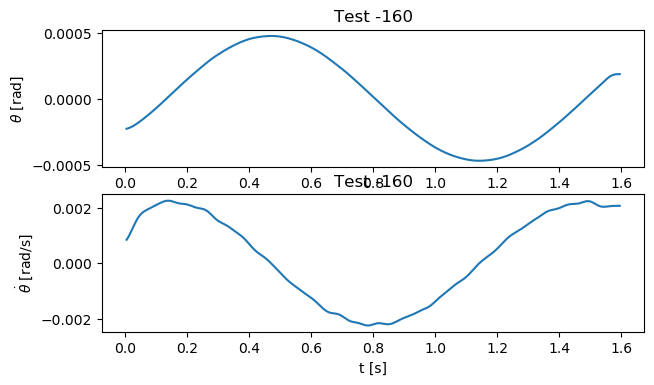

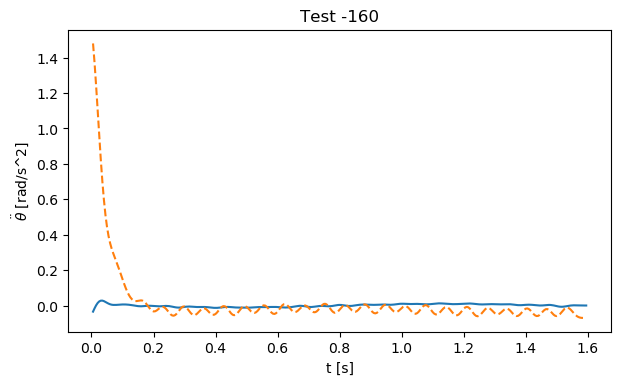

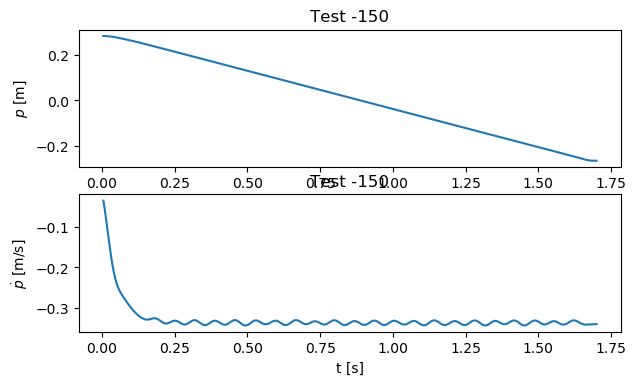

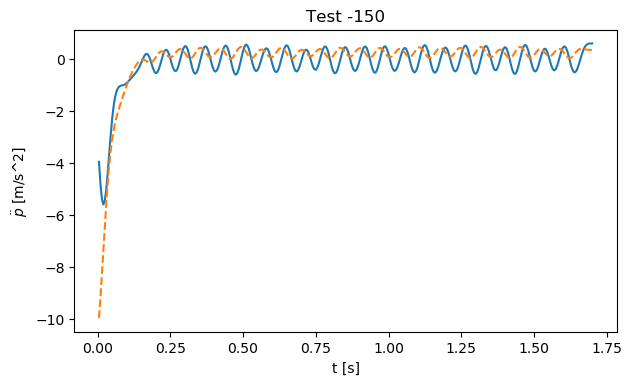

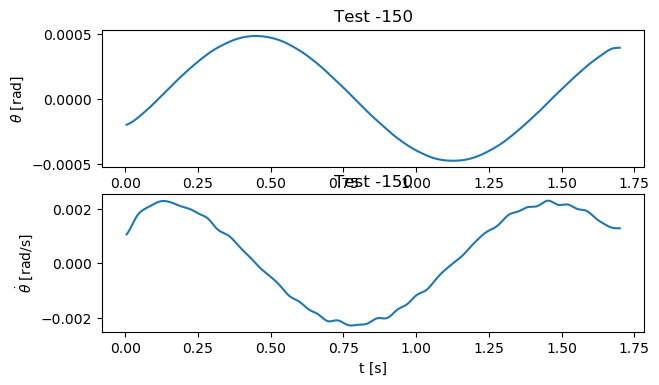

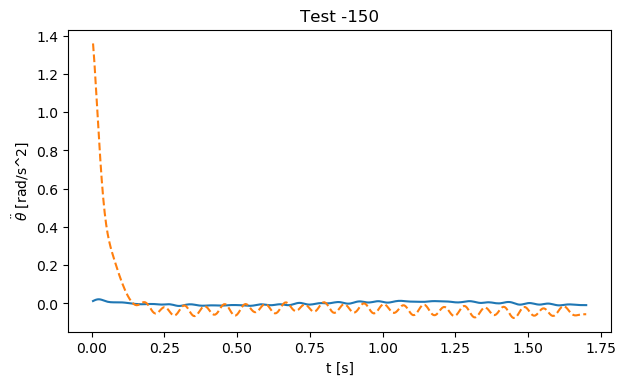

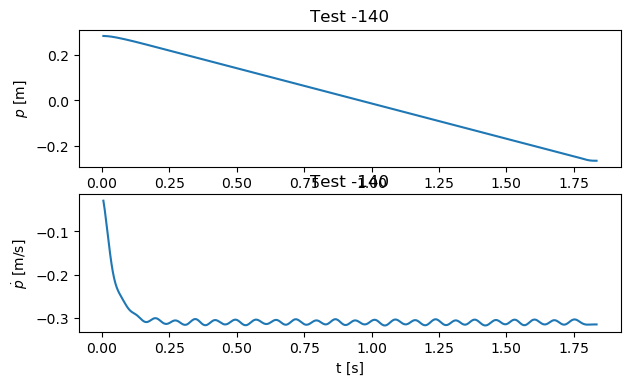

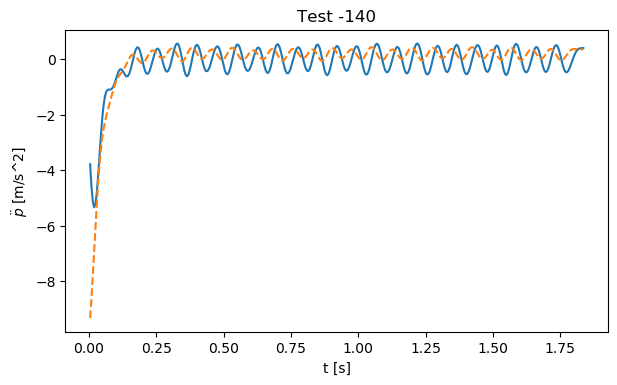

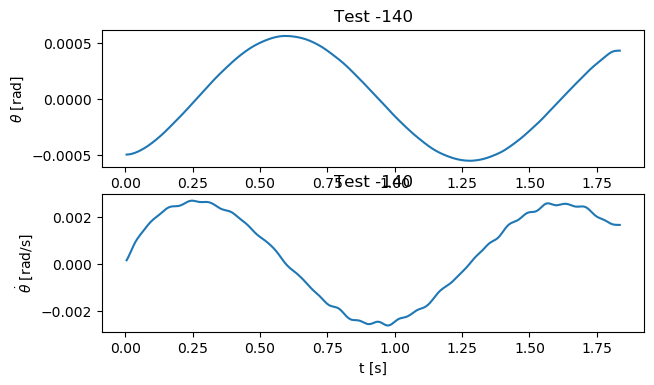

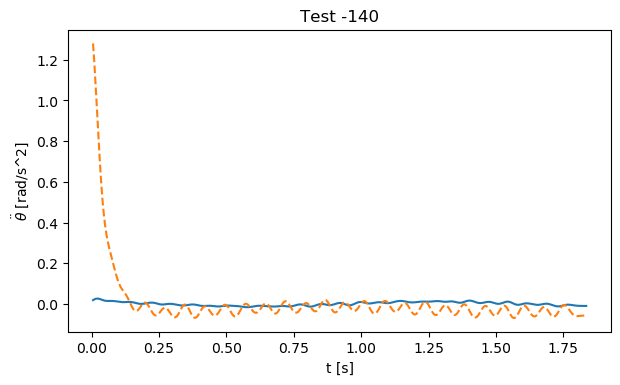

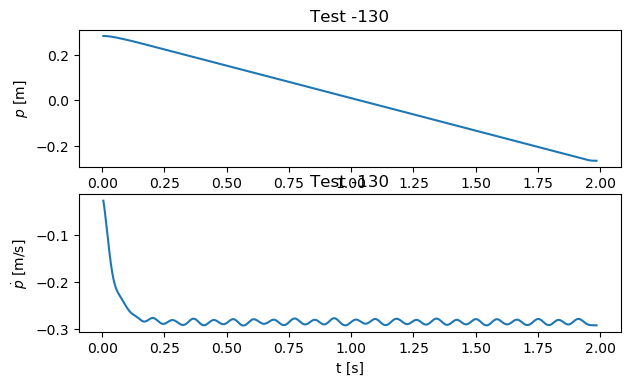

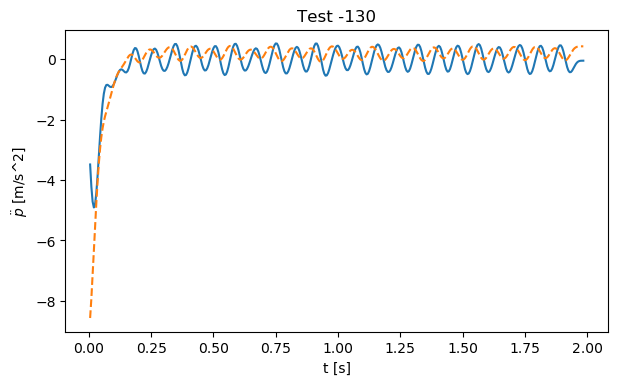

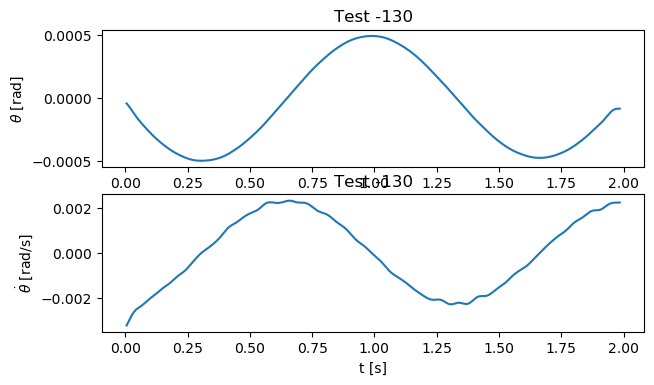

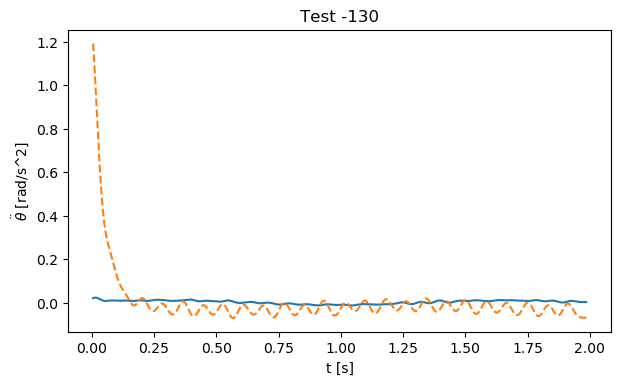

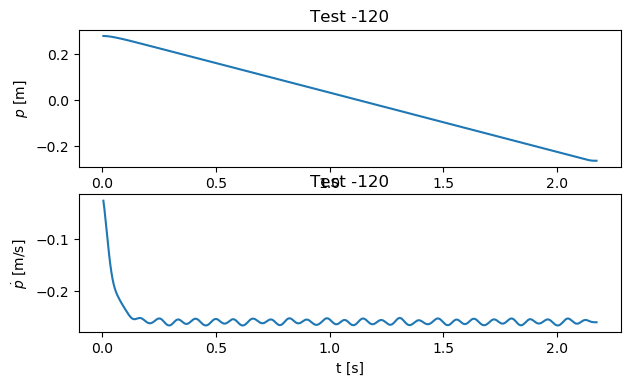

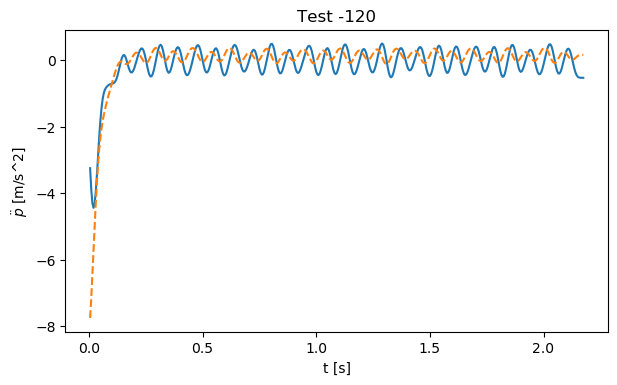

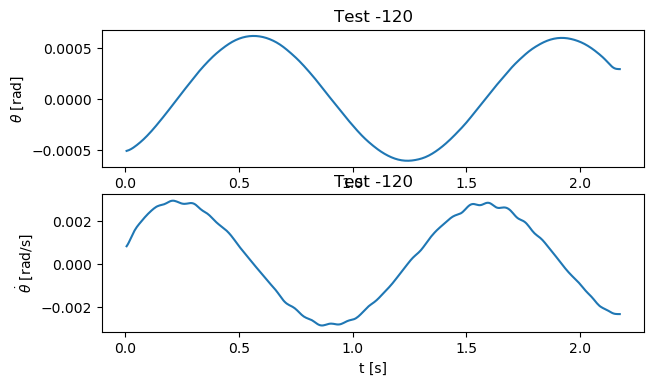

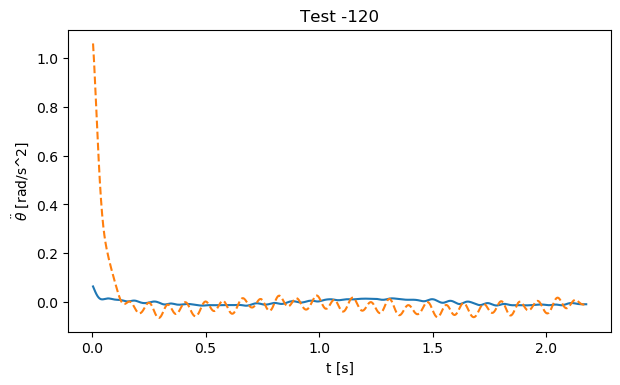

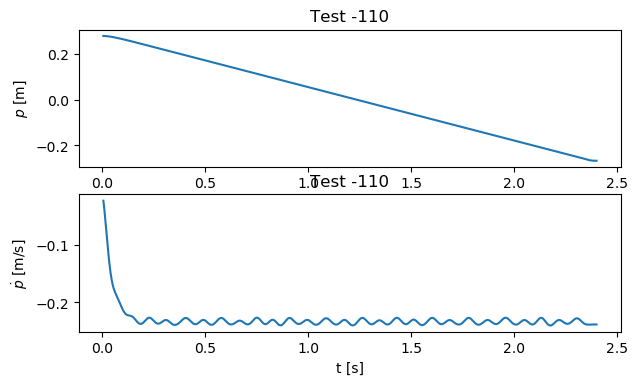

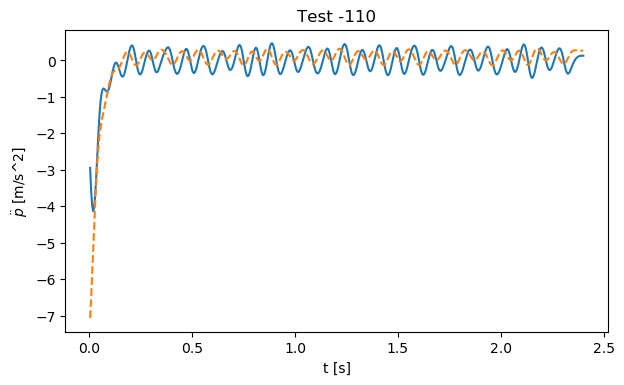

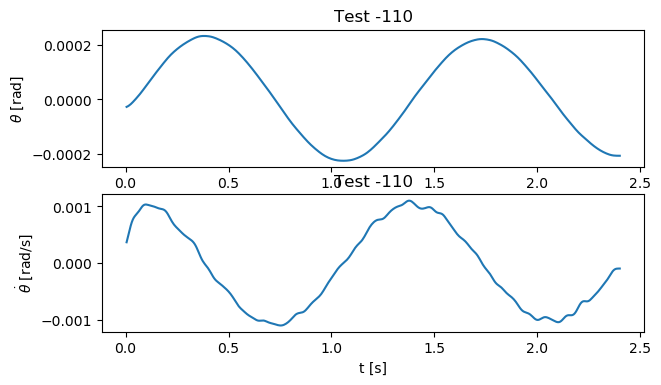

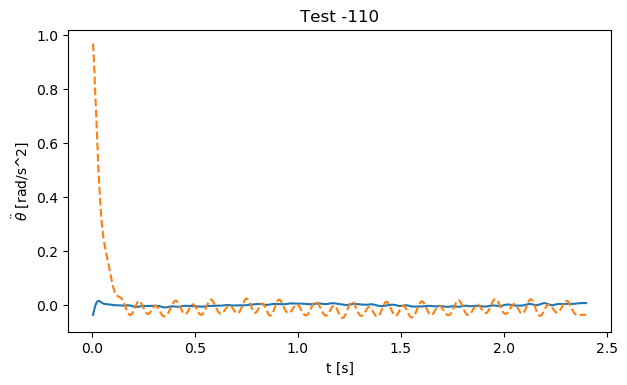

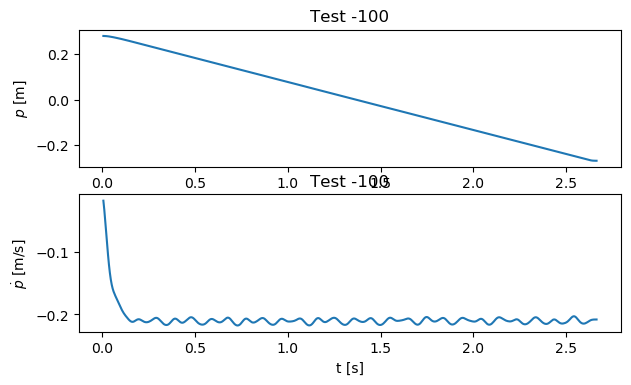

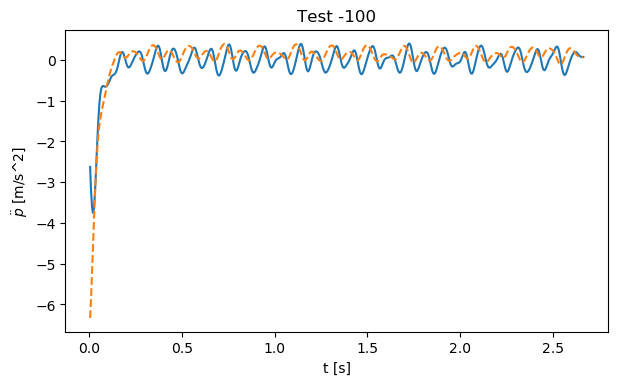

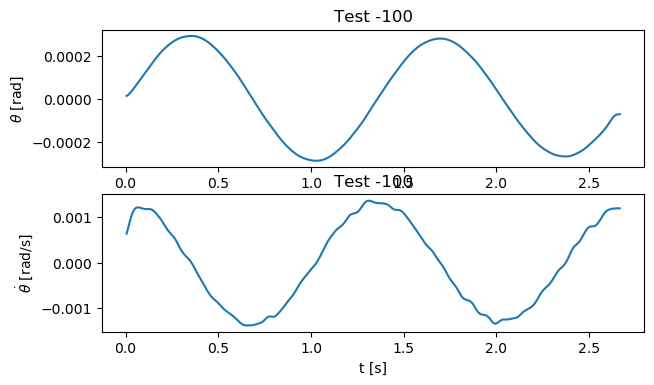

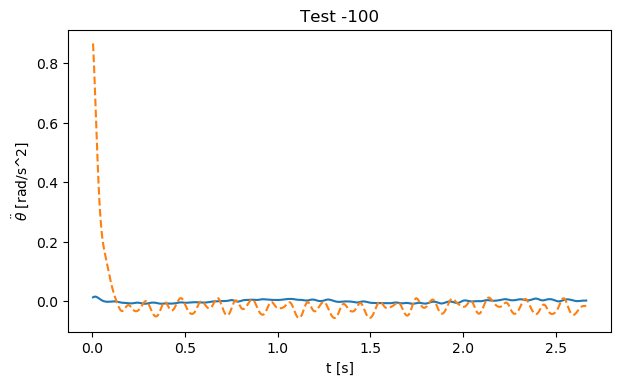

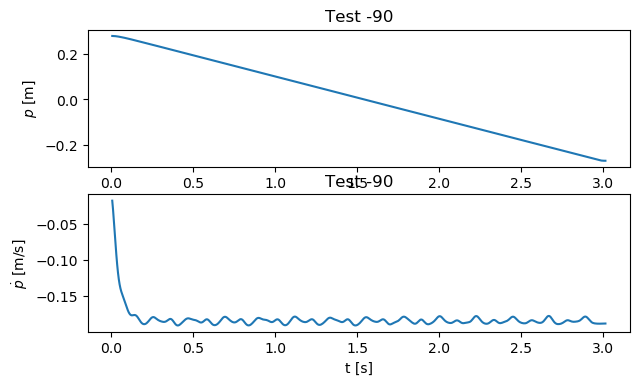

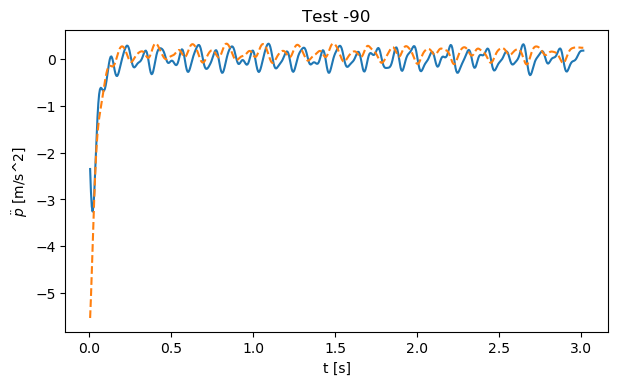

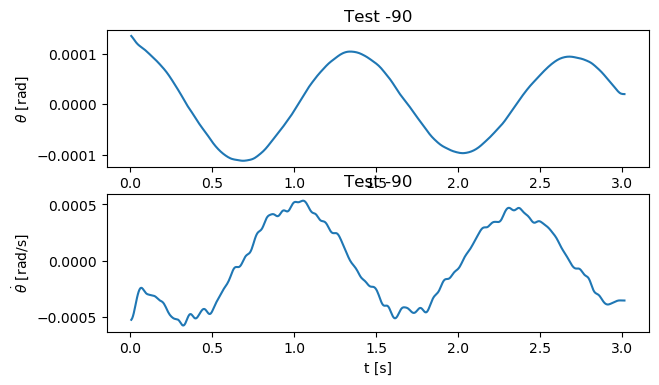

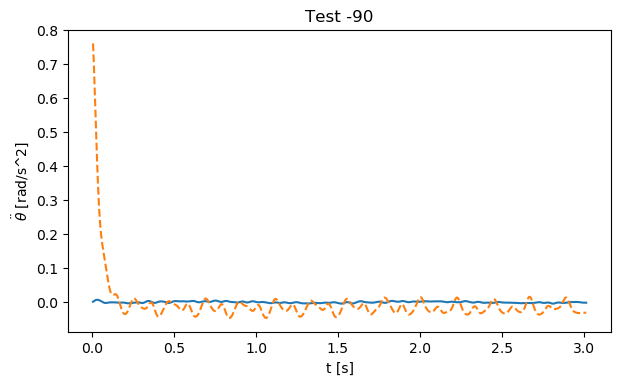

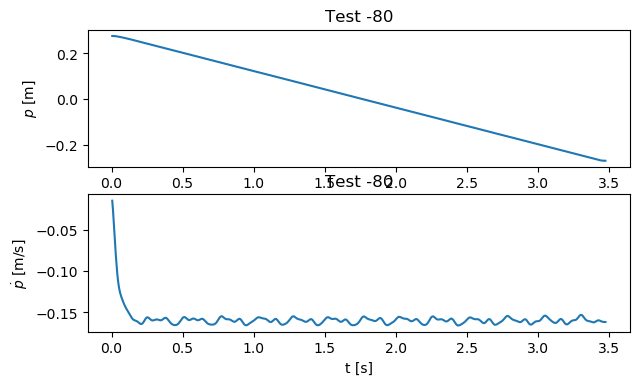

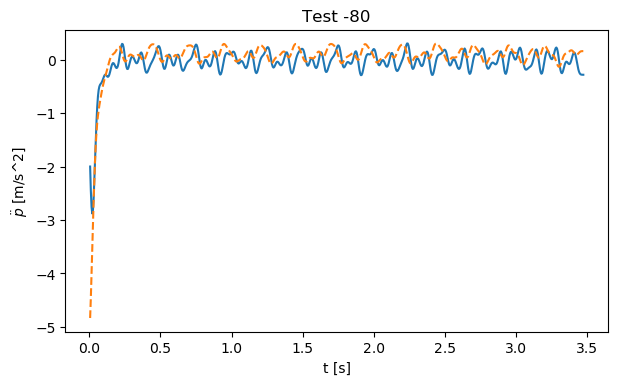

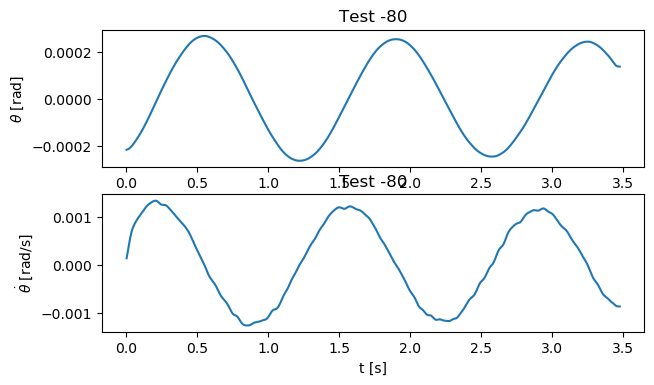

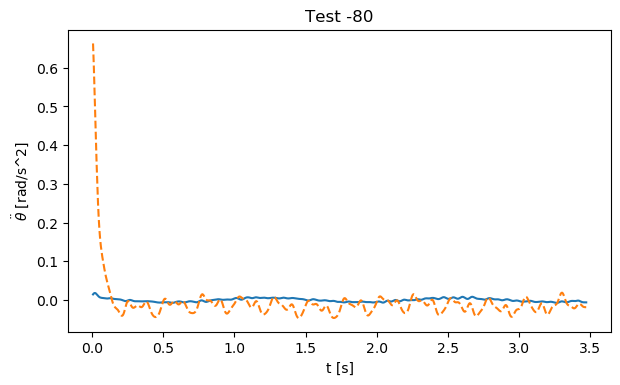

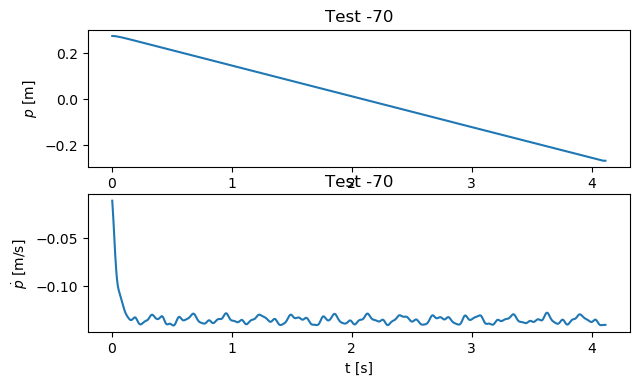

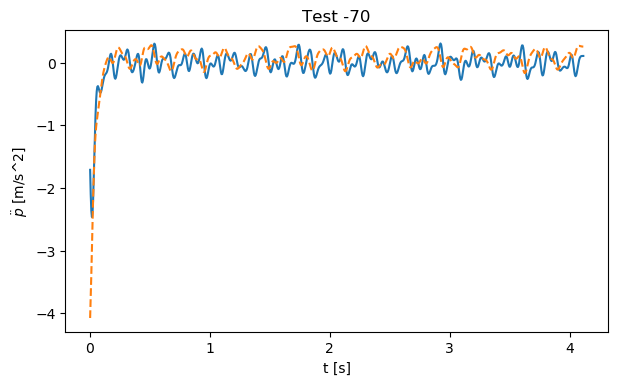

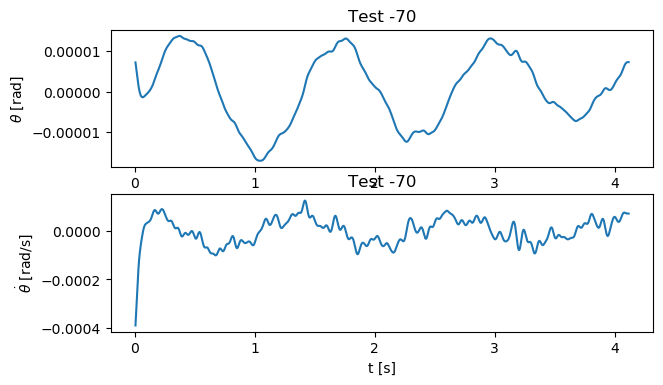

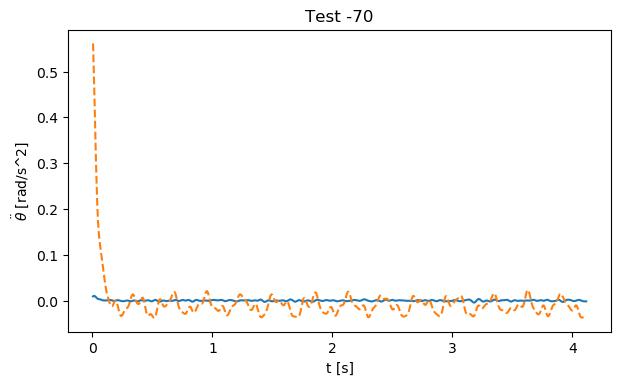

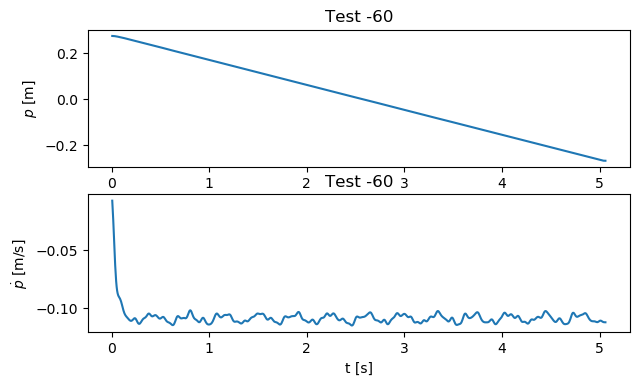

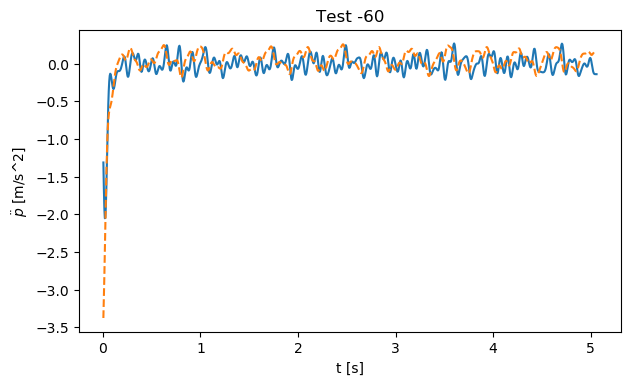

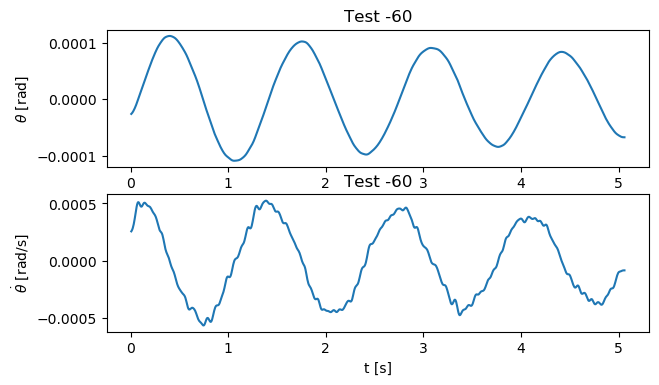

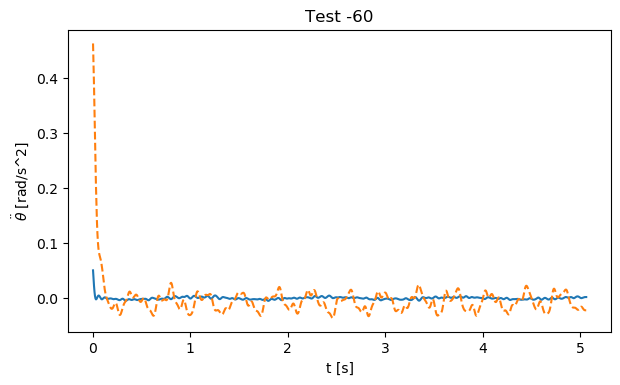

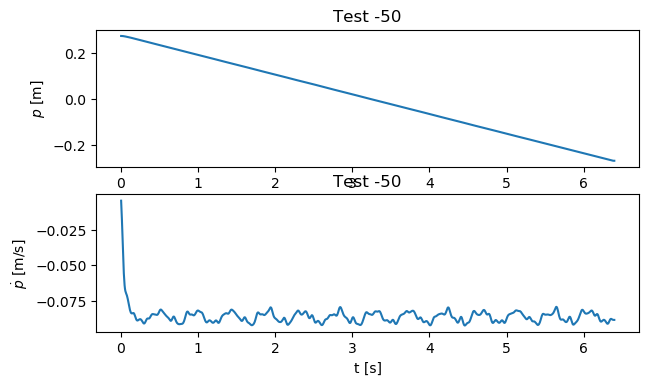

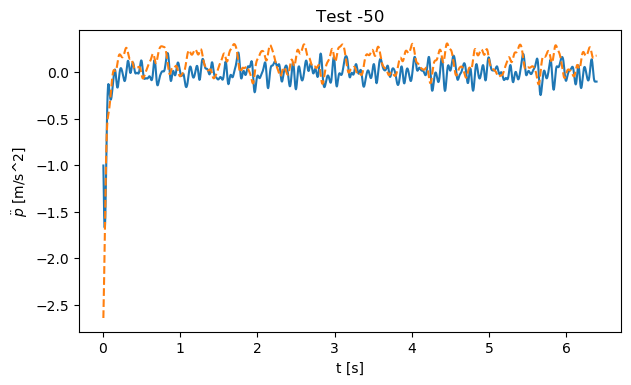

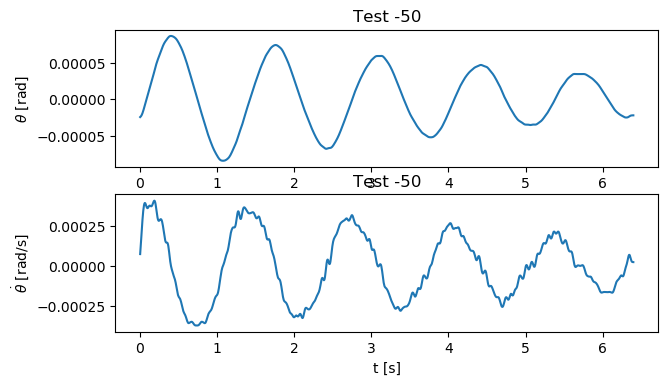

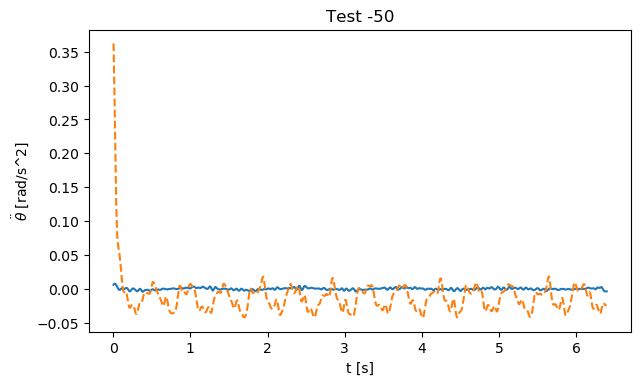

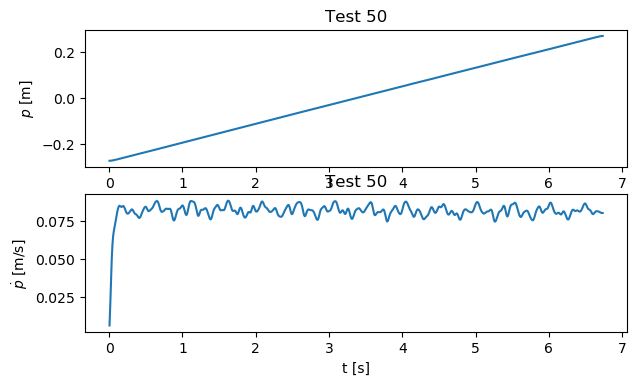

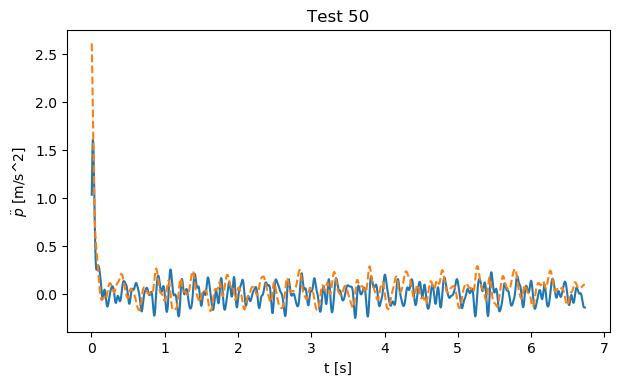

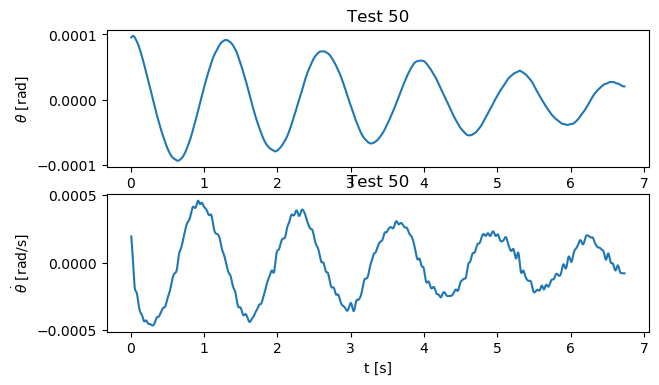

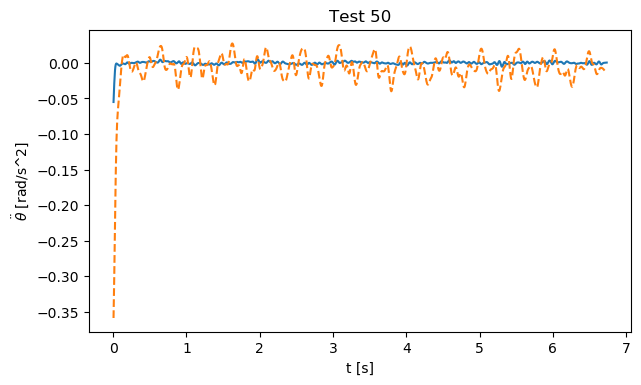

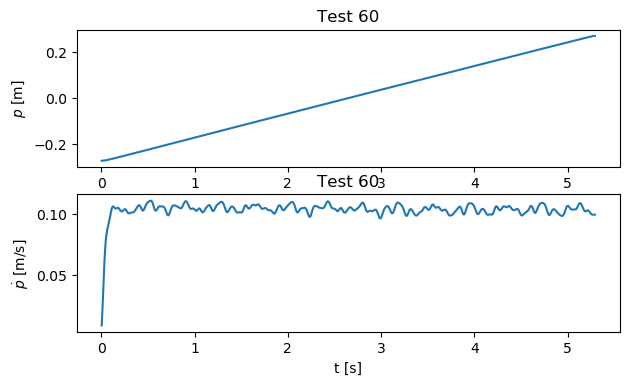

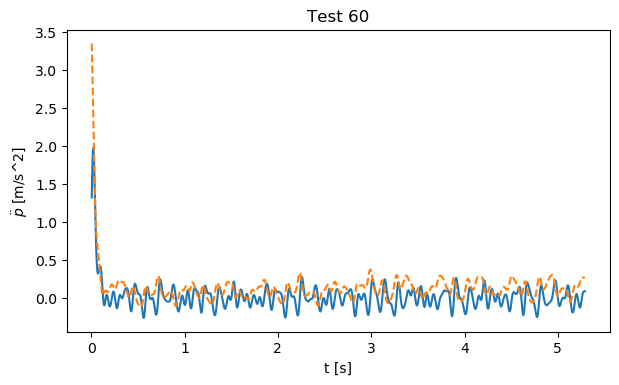

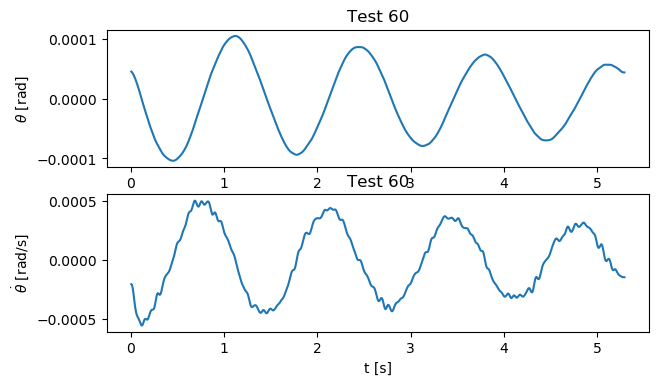

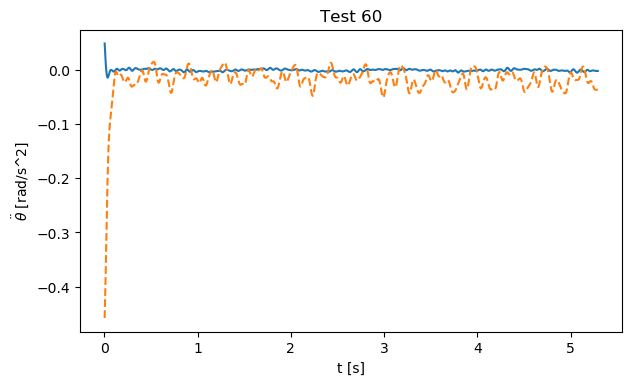

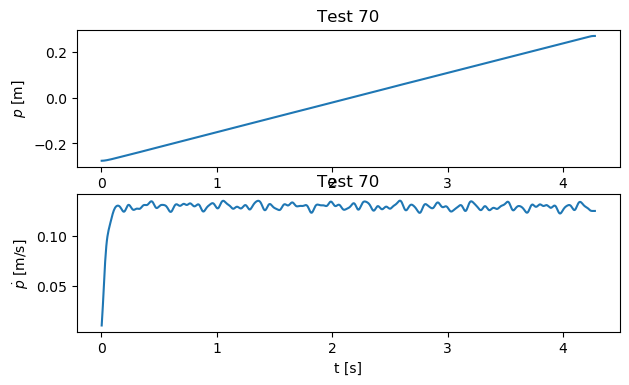

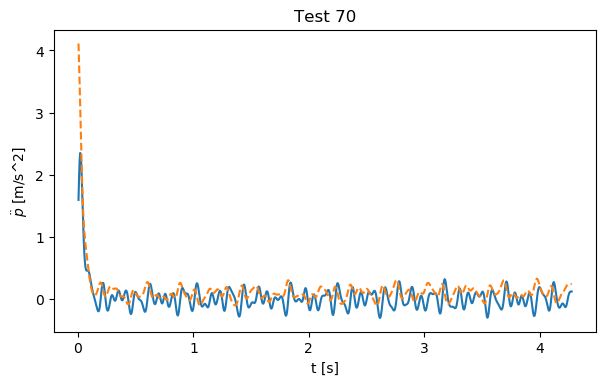

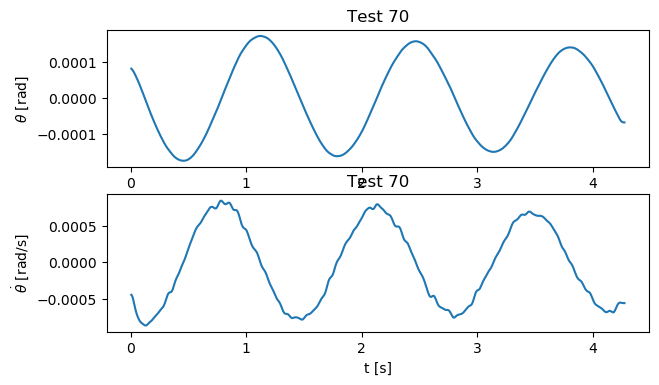

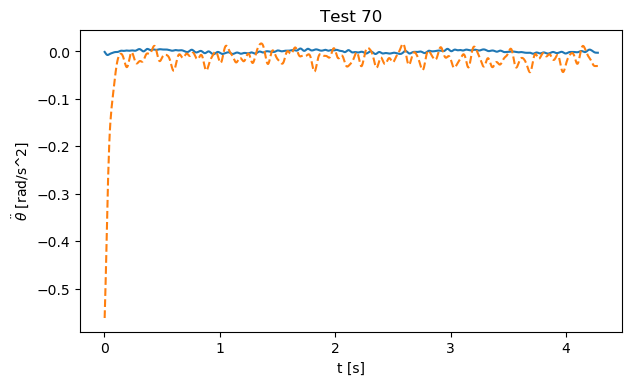

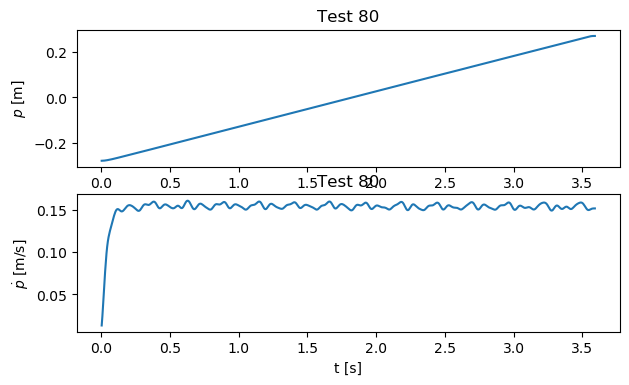

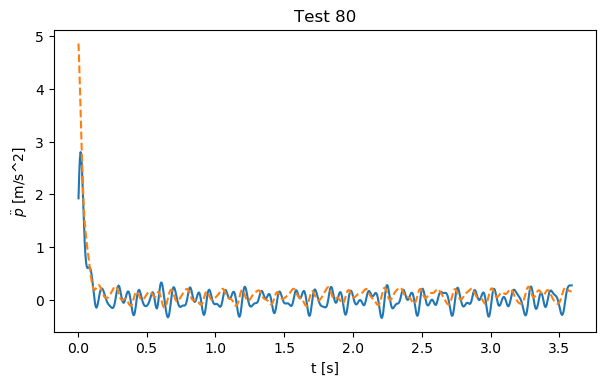

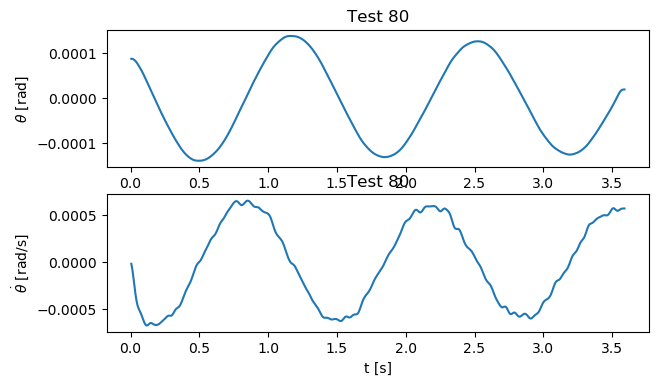

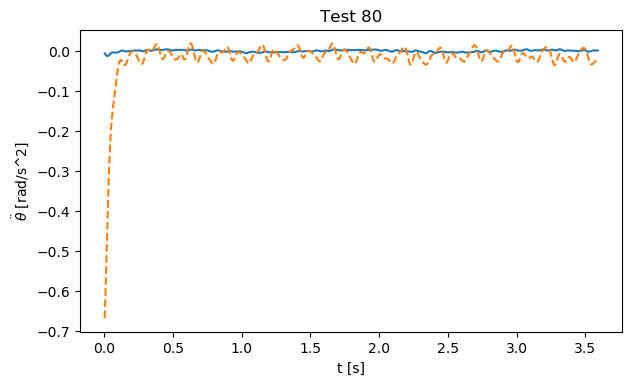

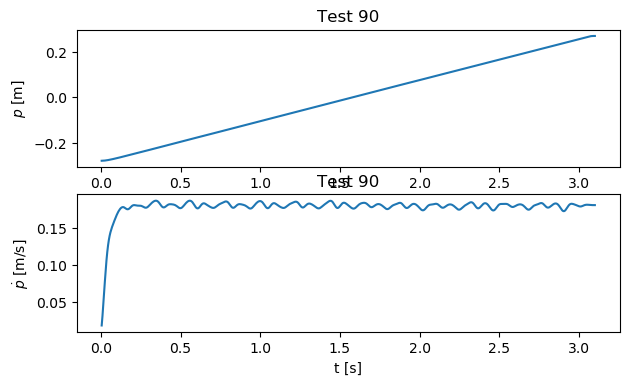

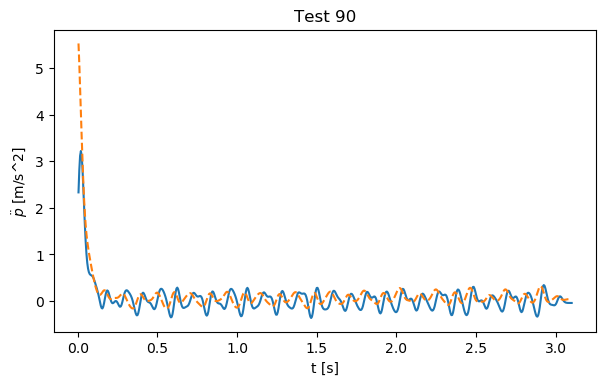

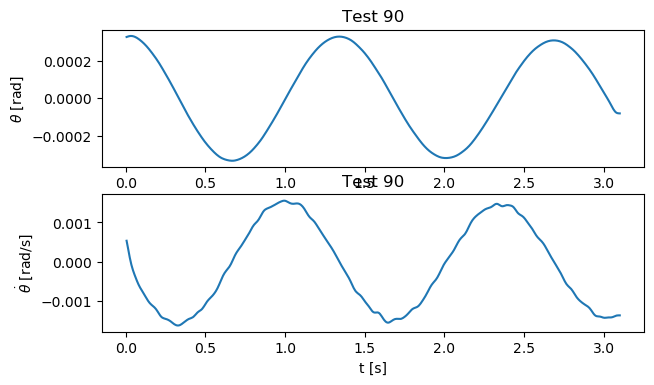

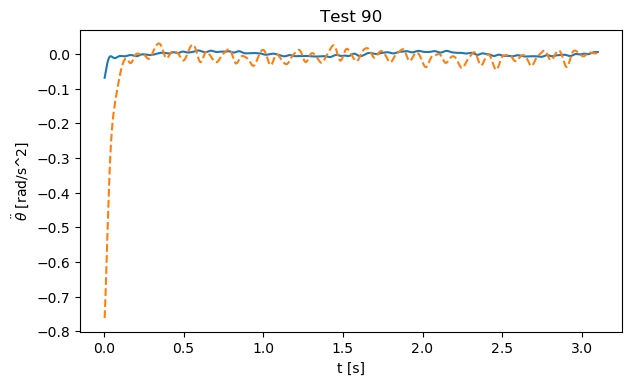

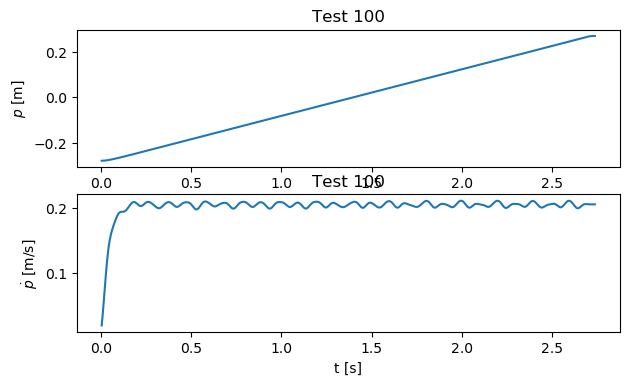

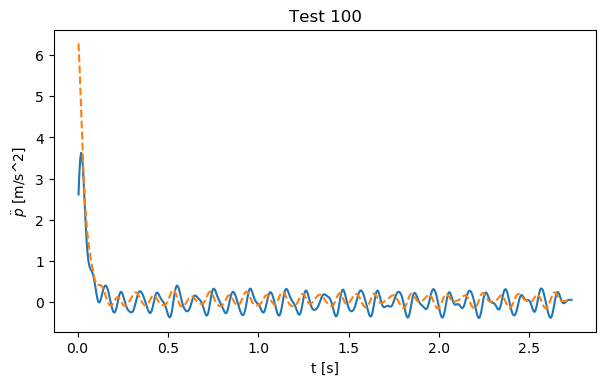

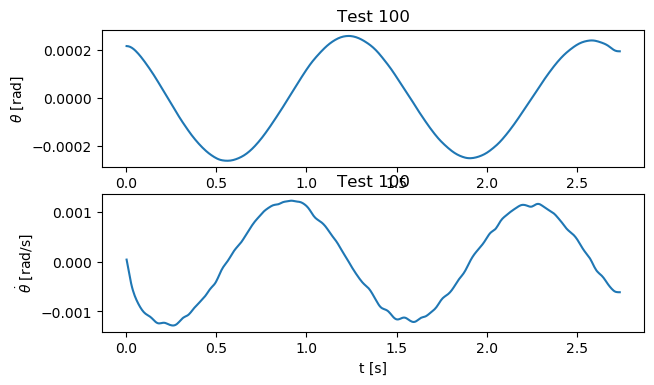

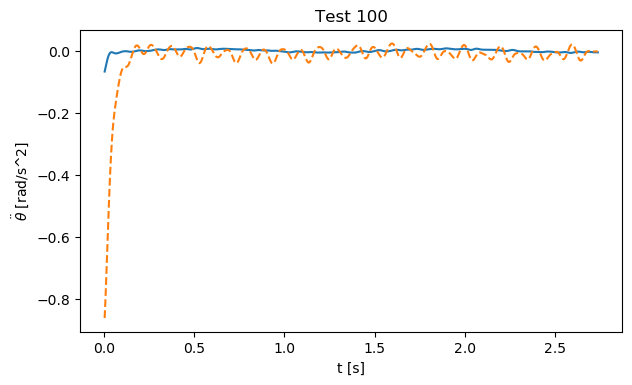

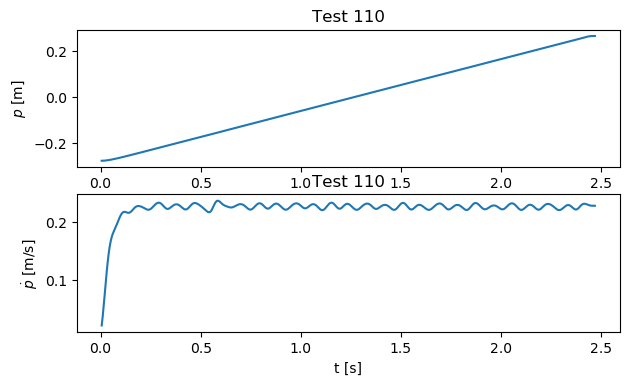

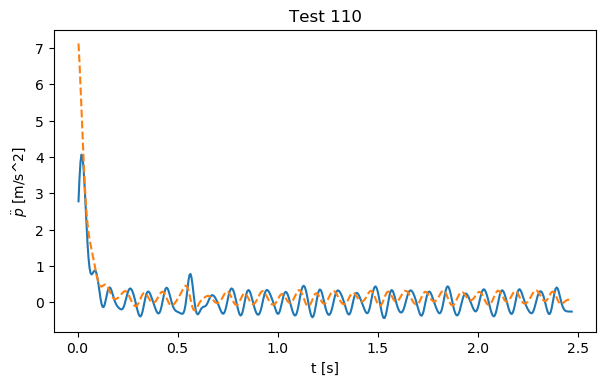

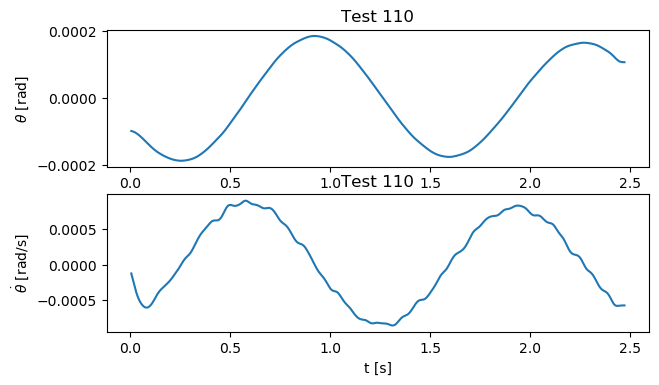

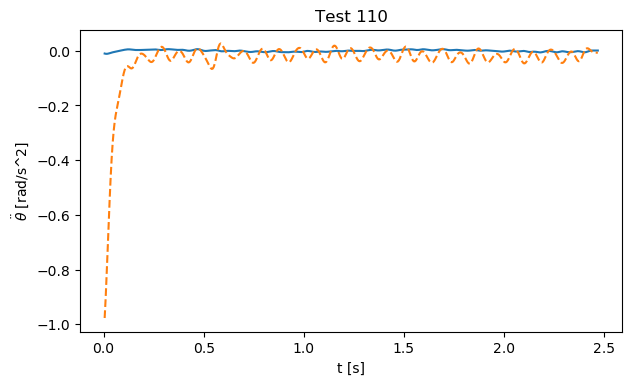

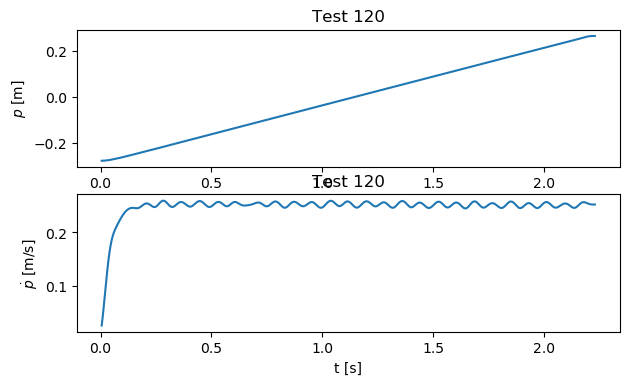

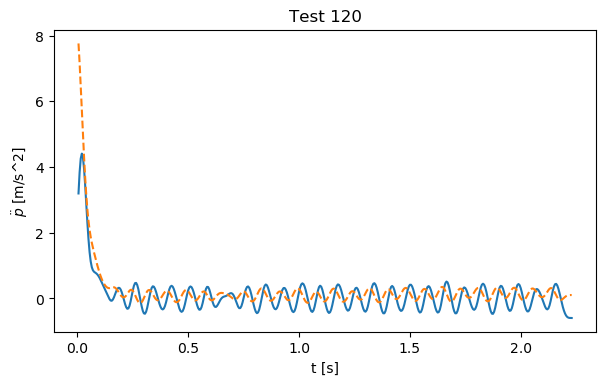

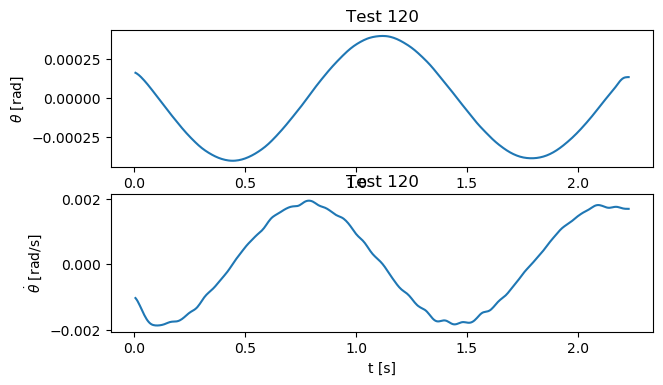

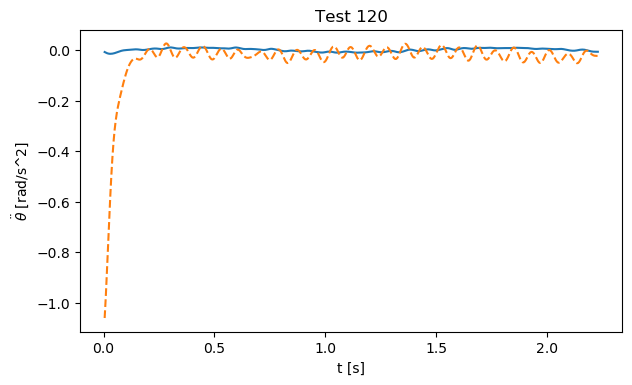

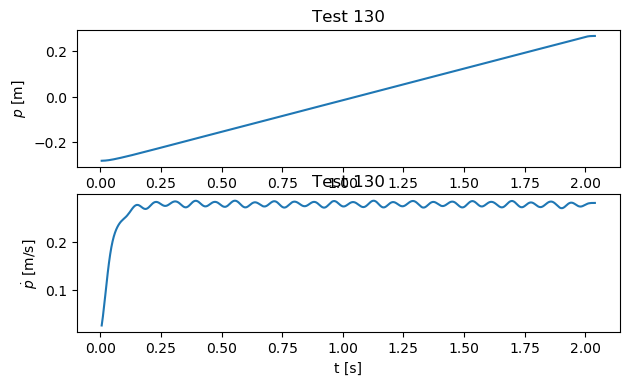

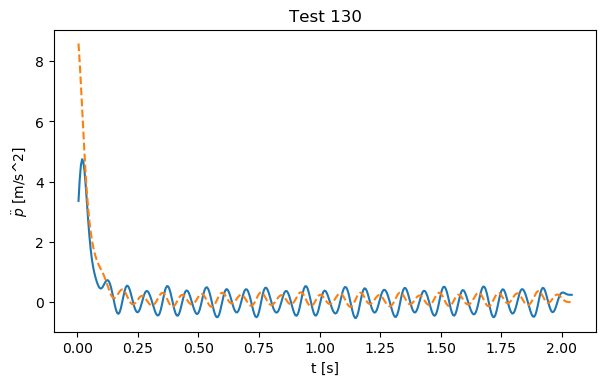

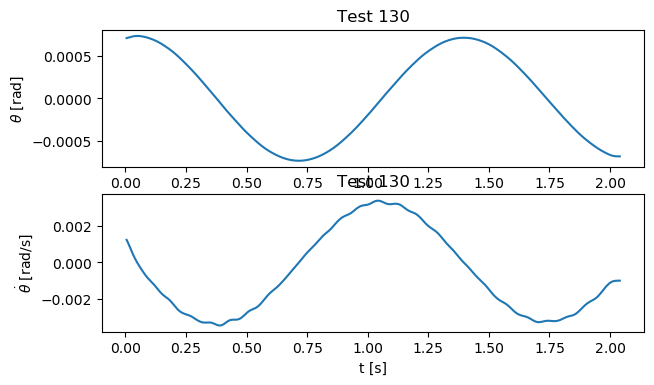

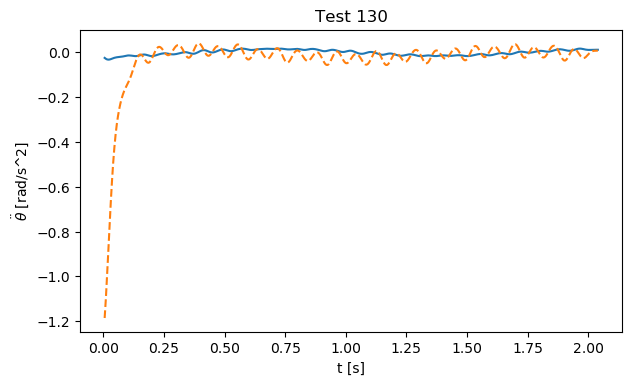

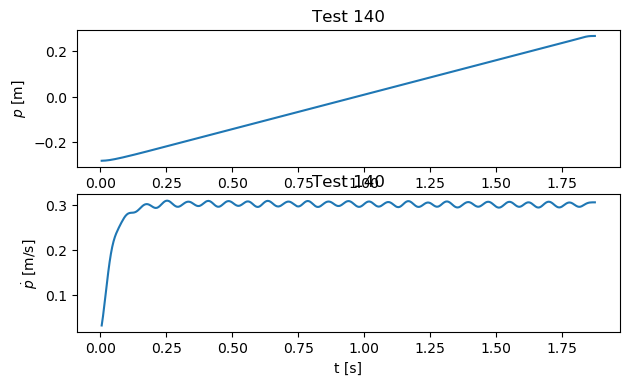

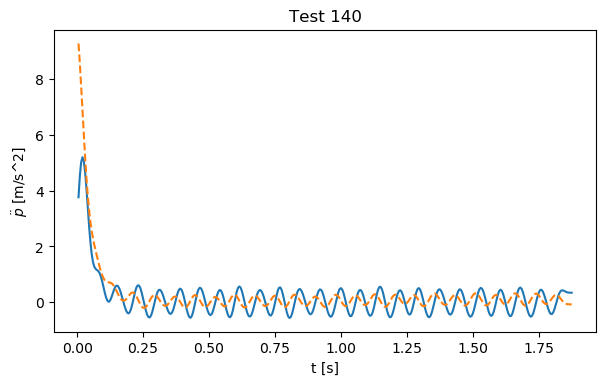

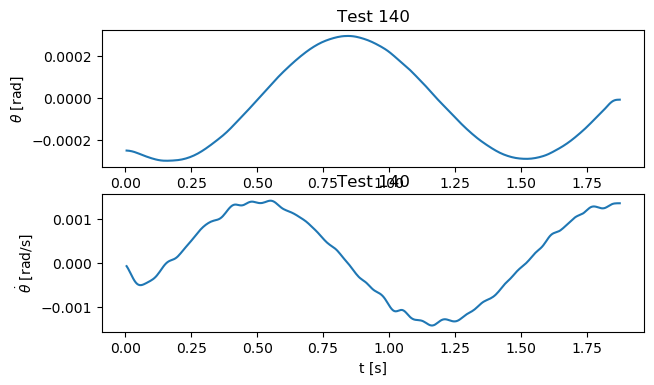

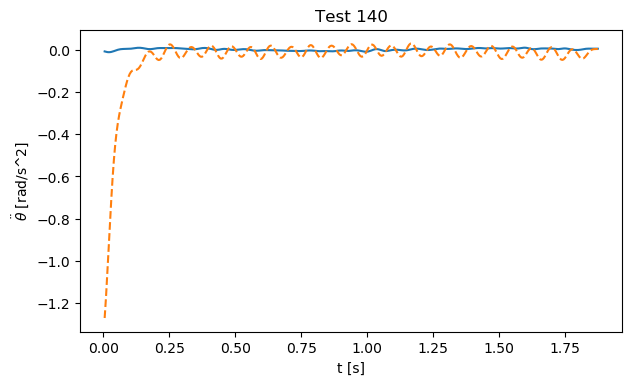

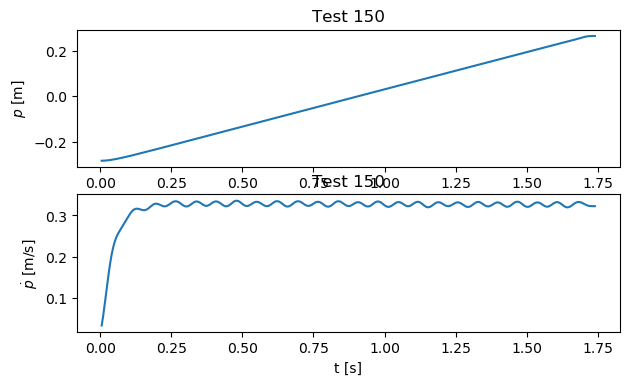

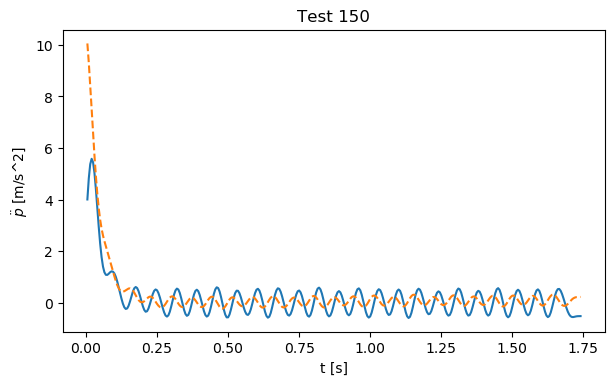

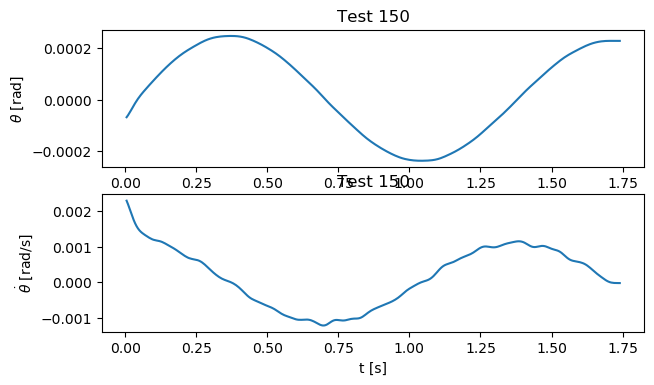

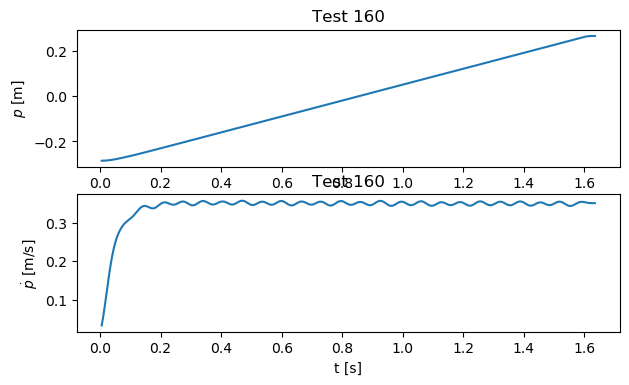

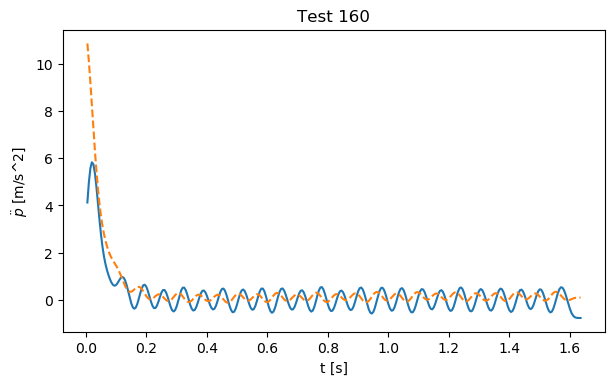

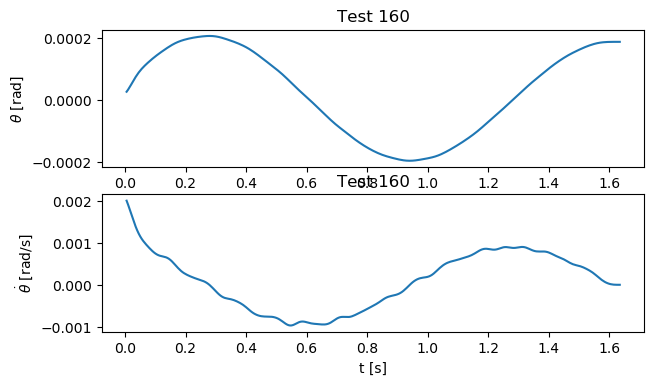

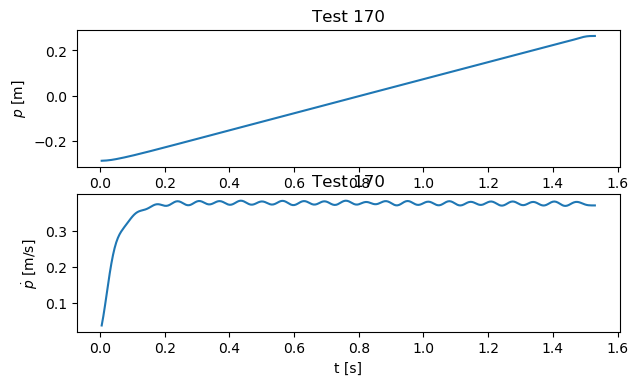

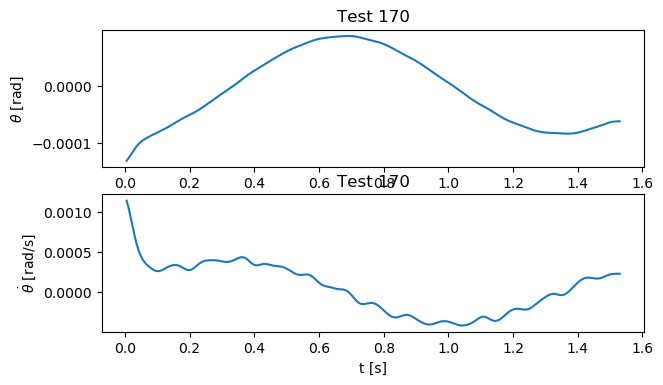

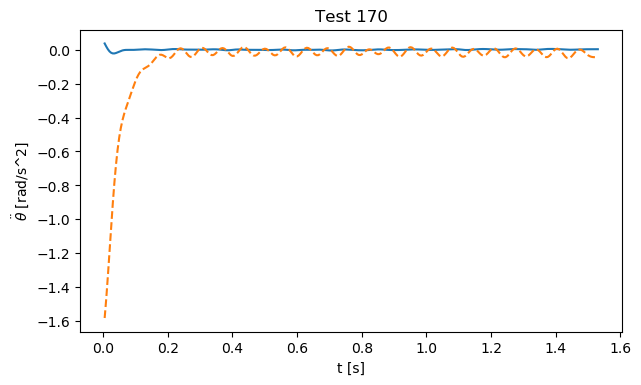

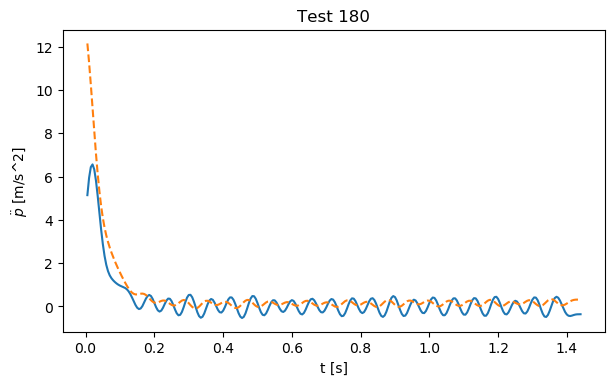

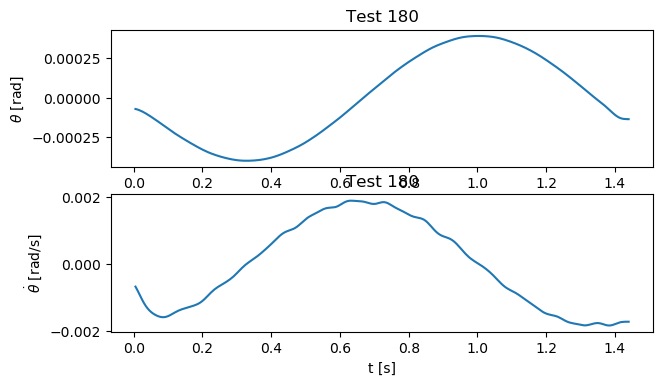

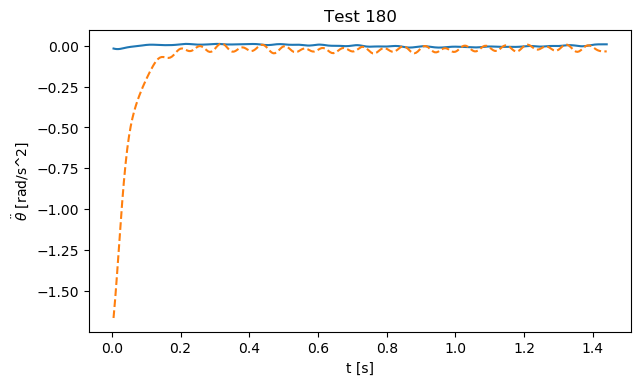

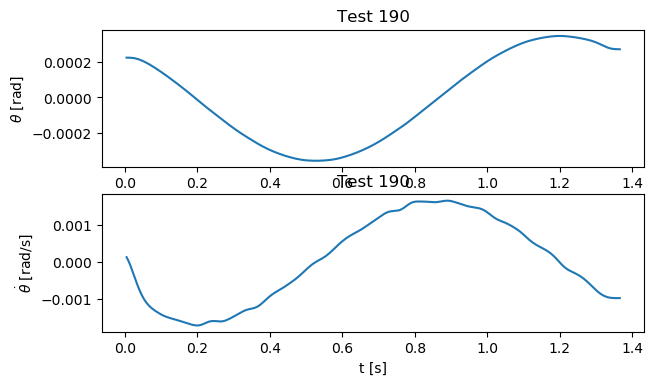

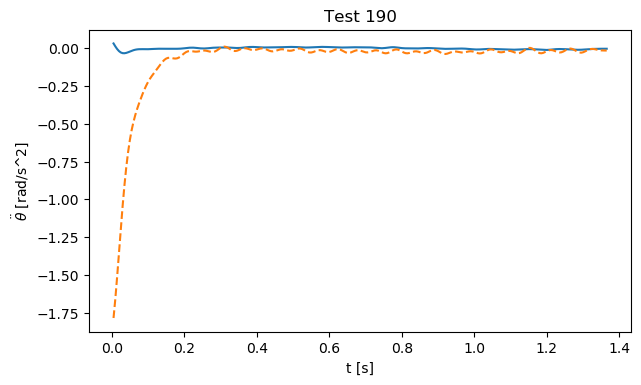

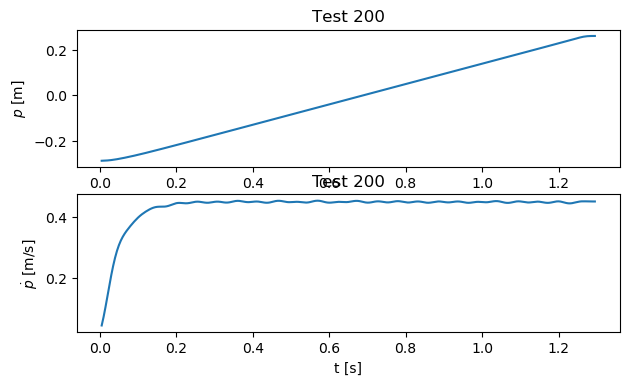

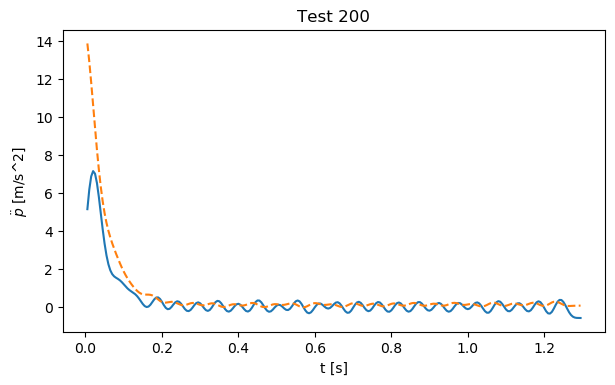

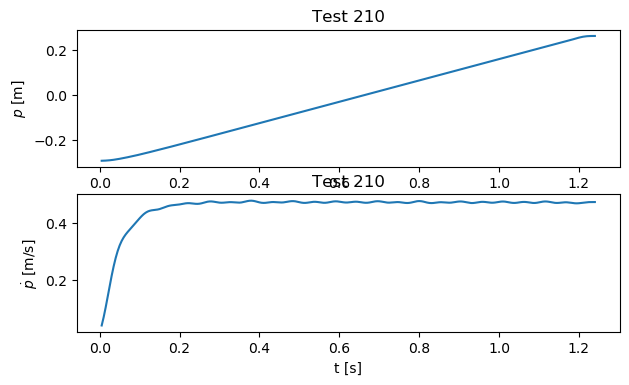

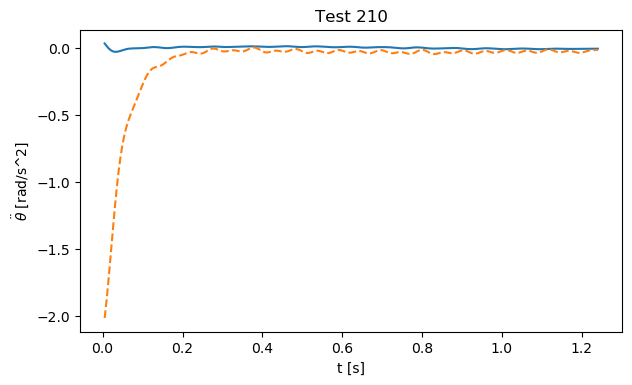

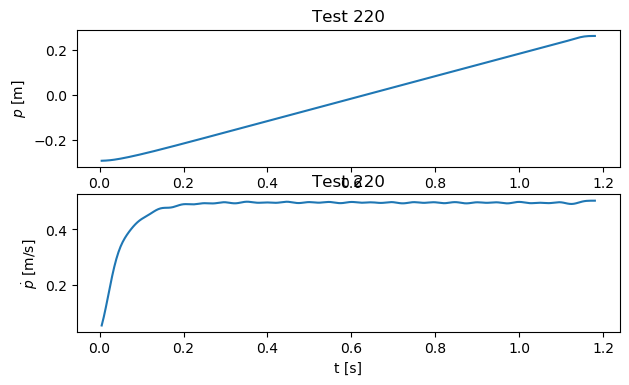

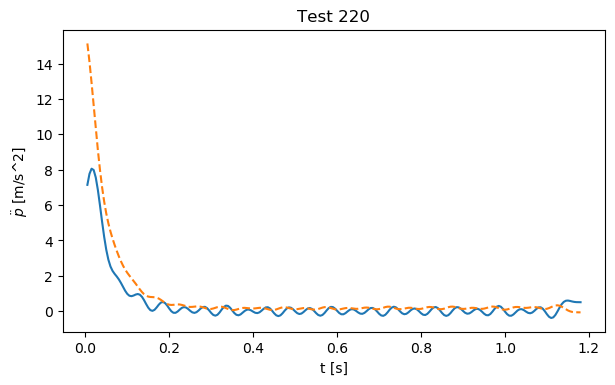

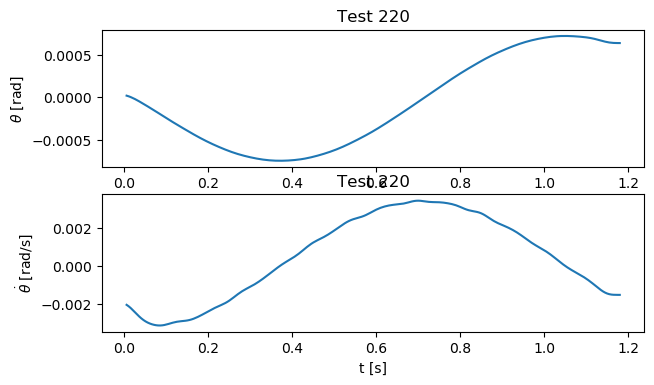

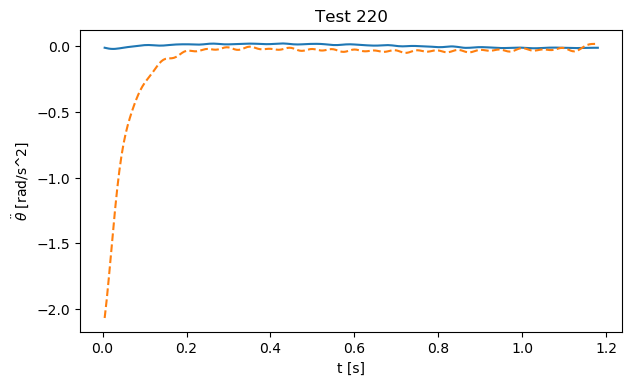

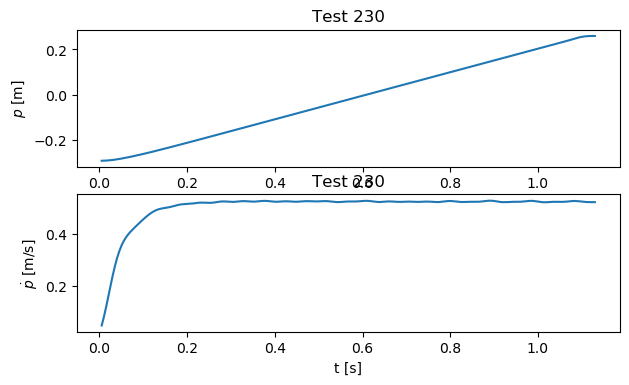

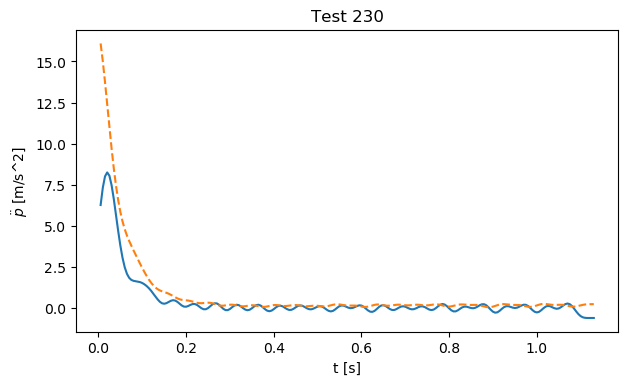

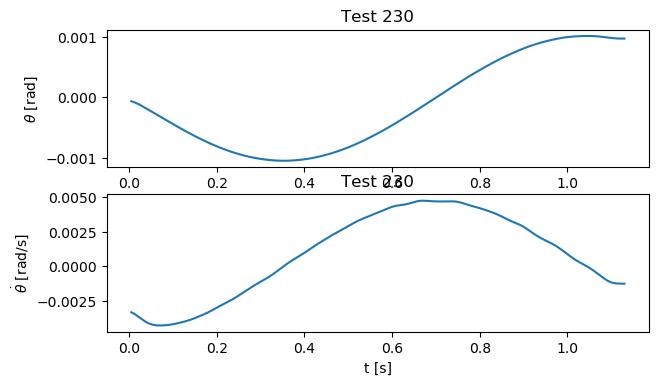

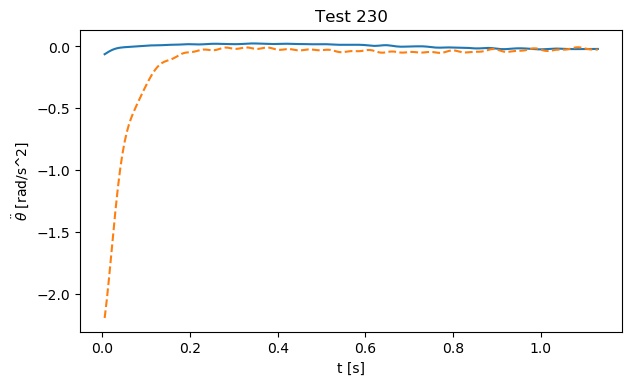

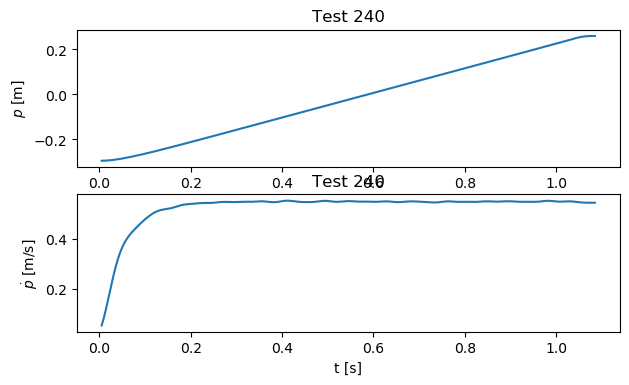

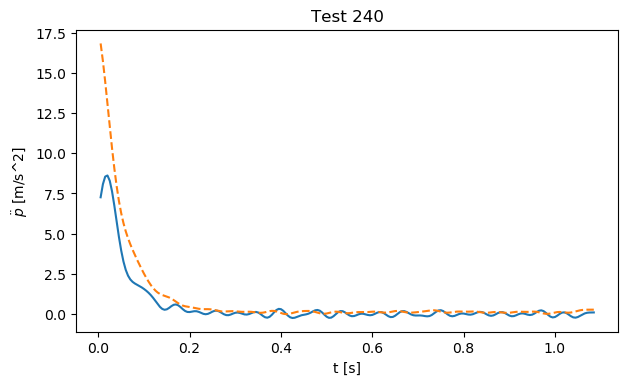

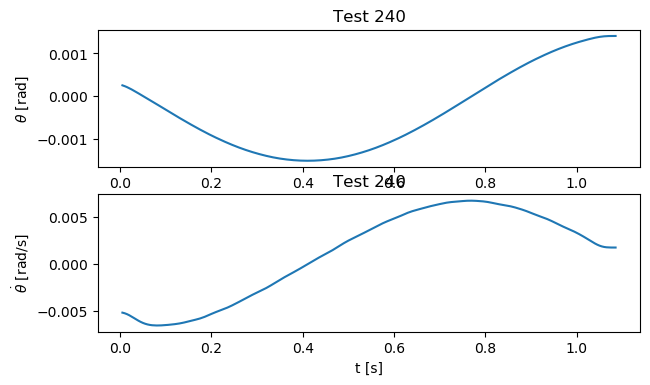

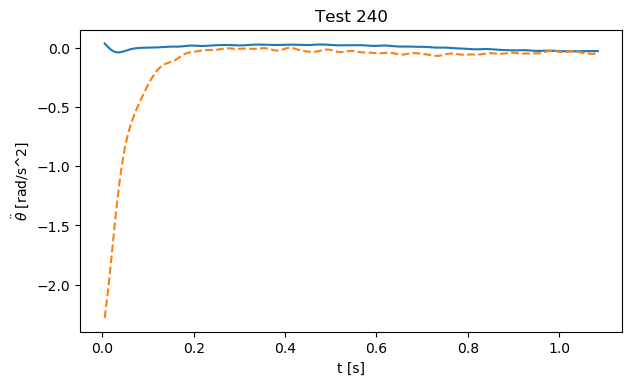

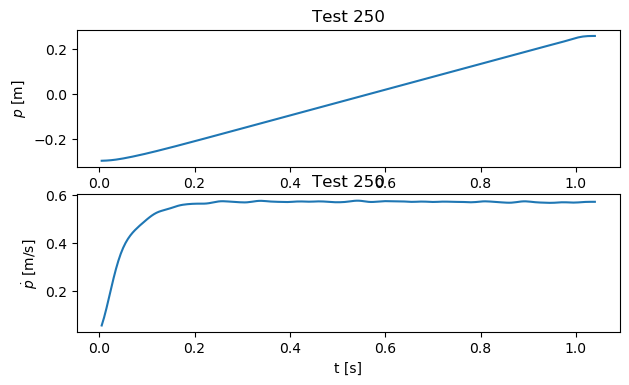

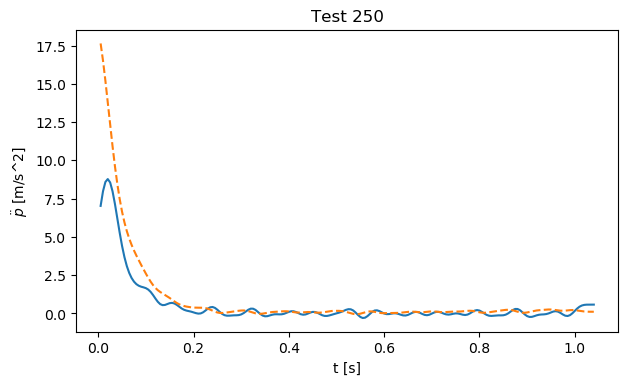

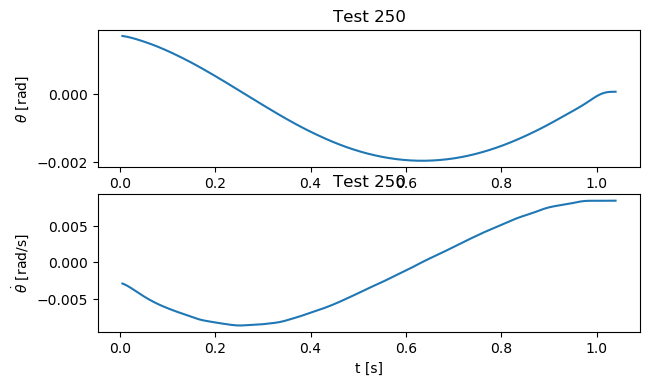

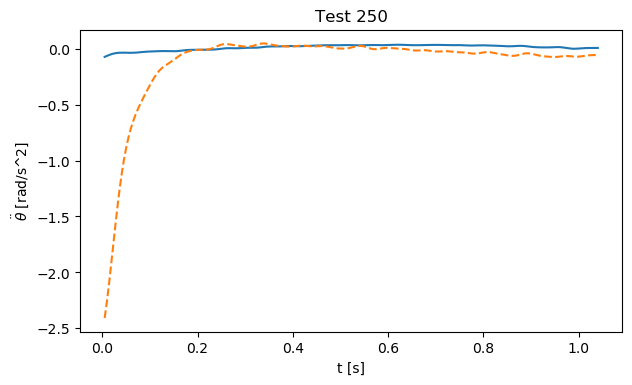

In [27]:
# Show results

for test_id, test_data in data.items():
    fig1,(p_ax,pd_ax) = plt.subplots(2,1)
    fig2,pdd_ax = plt.subplots()
    fig3,(t_ax,td_ax) = plt.subplots(2,1)
    fig4,tdd_ax = plt.subplots()
    t = test_data.get('time_us')
    t = t / 1e6
    t = t - t[0] # t[0]=0
    t2 = t[1:-1] # for velocity and acceleration signals
    dt = np.average(np.diff(t))
    # raw signals
    posraw = test_data.get('position')
    posdraw = np.convolve(posraw, [0.5, 0, -0.5], 'valid') / dt
    posddraw = np.convolve(posraw, [1.0, -2.0, 1.0], 'valid') / (dt**2)
    angraw = test_data.get('angle') * (2*np.pi/4000)
    angdraw = np.convolve(angraw, [0.5, 0, -0.5], 'valid') / dt
    angddraw = np.convolve(angraw, [1.0, -2.0, 1.0], 'valid') / (dt**2)
    uraw = test_data.get('pwm')
    # filter the signals
    b,a = signal.butter(Nf, 2*(dt*fc)) # [1],[1,0] = no filter
    pos = signal.filtfilt(b, a, posraw, padtype=None)
    posd = signal.filtfilt(b, a, posdraw, padtype=None)
    posdd = signal.filtfilt(b, a, posddraw, padtype=None)
    ang = signal.filtfilt(b, a, angraw, padtype=None)
    angd = signal.filtfilt(b, a, angdraw, padtype=None)
    angdd = signal.filtfilt(b, a, angddraw, padtype=None)
    u = signal.filtfilt(b, a, uraw, padtype=None)
    # shorten some signals
    t = t[1:-1]
    pos = pos[1:-1]
    ang = ang[1:-1]
    u = u[1:-1]
    # "prediction"
    f1 = u + mua*angd**2*np.sin(ang) - fva*posd - fsa*np.sign(posd)
    f2 = -mua*g*np.sin(ang) - tva*angd
    den = ma*Ia - (mua*np.cos(ang))**2
    posdd_hat = (Ia*f1 - mua*np.cos(ang)*f2)/den
    angdd_hat = (-mua*np.cos(ang)*f1 + ma*f2)/den
    
    p_ax.plot(t, pos)
    pd_ax.plot(t2, posd)
    pdd_ax.plot(t2, posdd)
    pdd_ax.plot(t2, posdd_hat, '--')
    
    t_ax.plot(t, ang)
    td_ax.plot(t2, angd)
    tdd_ax.plot(t2, angdd)
    tdd_ax.plot(t2, angdd_hat, '--')
    
    p_ax.set_title(f"Test {int(test_id)}")
    p_ax.set_xlabel('t [s]')
    p_ax.set_ylabel('$p$ [m]')
    pd_ax.set_title(f"Test {int(test_id)}")
    pd_ax.set_xlabel('t [s]')
    pd_ax.set_ylabel('$\\dot{p}$ [m/s]')
    pdd_ax.set_title(f"Test {int(test_id)}")
    pdd_ax.set_xlabel('t [s]')
    pdd_ax.set_ylabel('$\\ddot{p}$ [m/s^2]')
    
    t_ax.set_title(f"Test {int(test_id)}")
    t_ax.set_xlabel('t [s]')
    t_ax.set_ylabel('$\\theta$ [rad]')
    td_ax.set_title(f"Test {int(test_id)}")
    td_ax.set_xlabel('t [s]')
    td_ax.set_ylabel('$\\dot{\\theta}$ [rad/s]')
    tdd_ax.set_title(f"Test {int(test_id)}")
    tdd_ax.set_xlabel('t [s]')
    tdd_ax.set_ylabel('$\\ddot{\\theta}$ [rad/s^2]')